In [810]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

phones_df = pd.read_csv("Cleaned_data.csv").join(pd.read_csv("PPI.csv"))

phones_df.set_index("phone",inplace= True)
phones_df.rename(columns={"0":"PPI"},inplace=True)
phones_df.drop(columns = "Unnamed: 0",inplace= True)
phones_df.drop(index=phones_df[phones_df["PPI"]!=phones_df["PPI"]].index,inplace=True)
%pylab inline
%config InlineBackend.figure_formats = ['retina']

sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler



Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['std', 'plot']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [811]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    val_score_2 = 1.0 - (1 - val_score) * (X_val.shape[0] - 1.) / (X_val.shape[0] - X_val.shape[1] - 1.)
    val_score3 = lr_model.score(X_val, y_val)


    # report results
    print('\nValidation R^2 score was:', val_score)
    print('\nValidation Adj R^2 score was:', val_score_2)

    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 
    return lr_model

In [812]:
phones_df.drop(index=phones_df[phones_df["PPI"]!=phones_df["PPI"]].index,inplace=True)

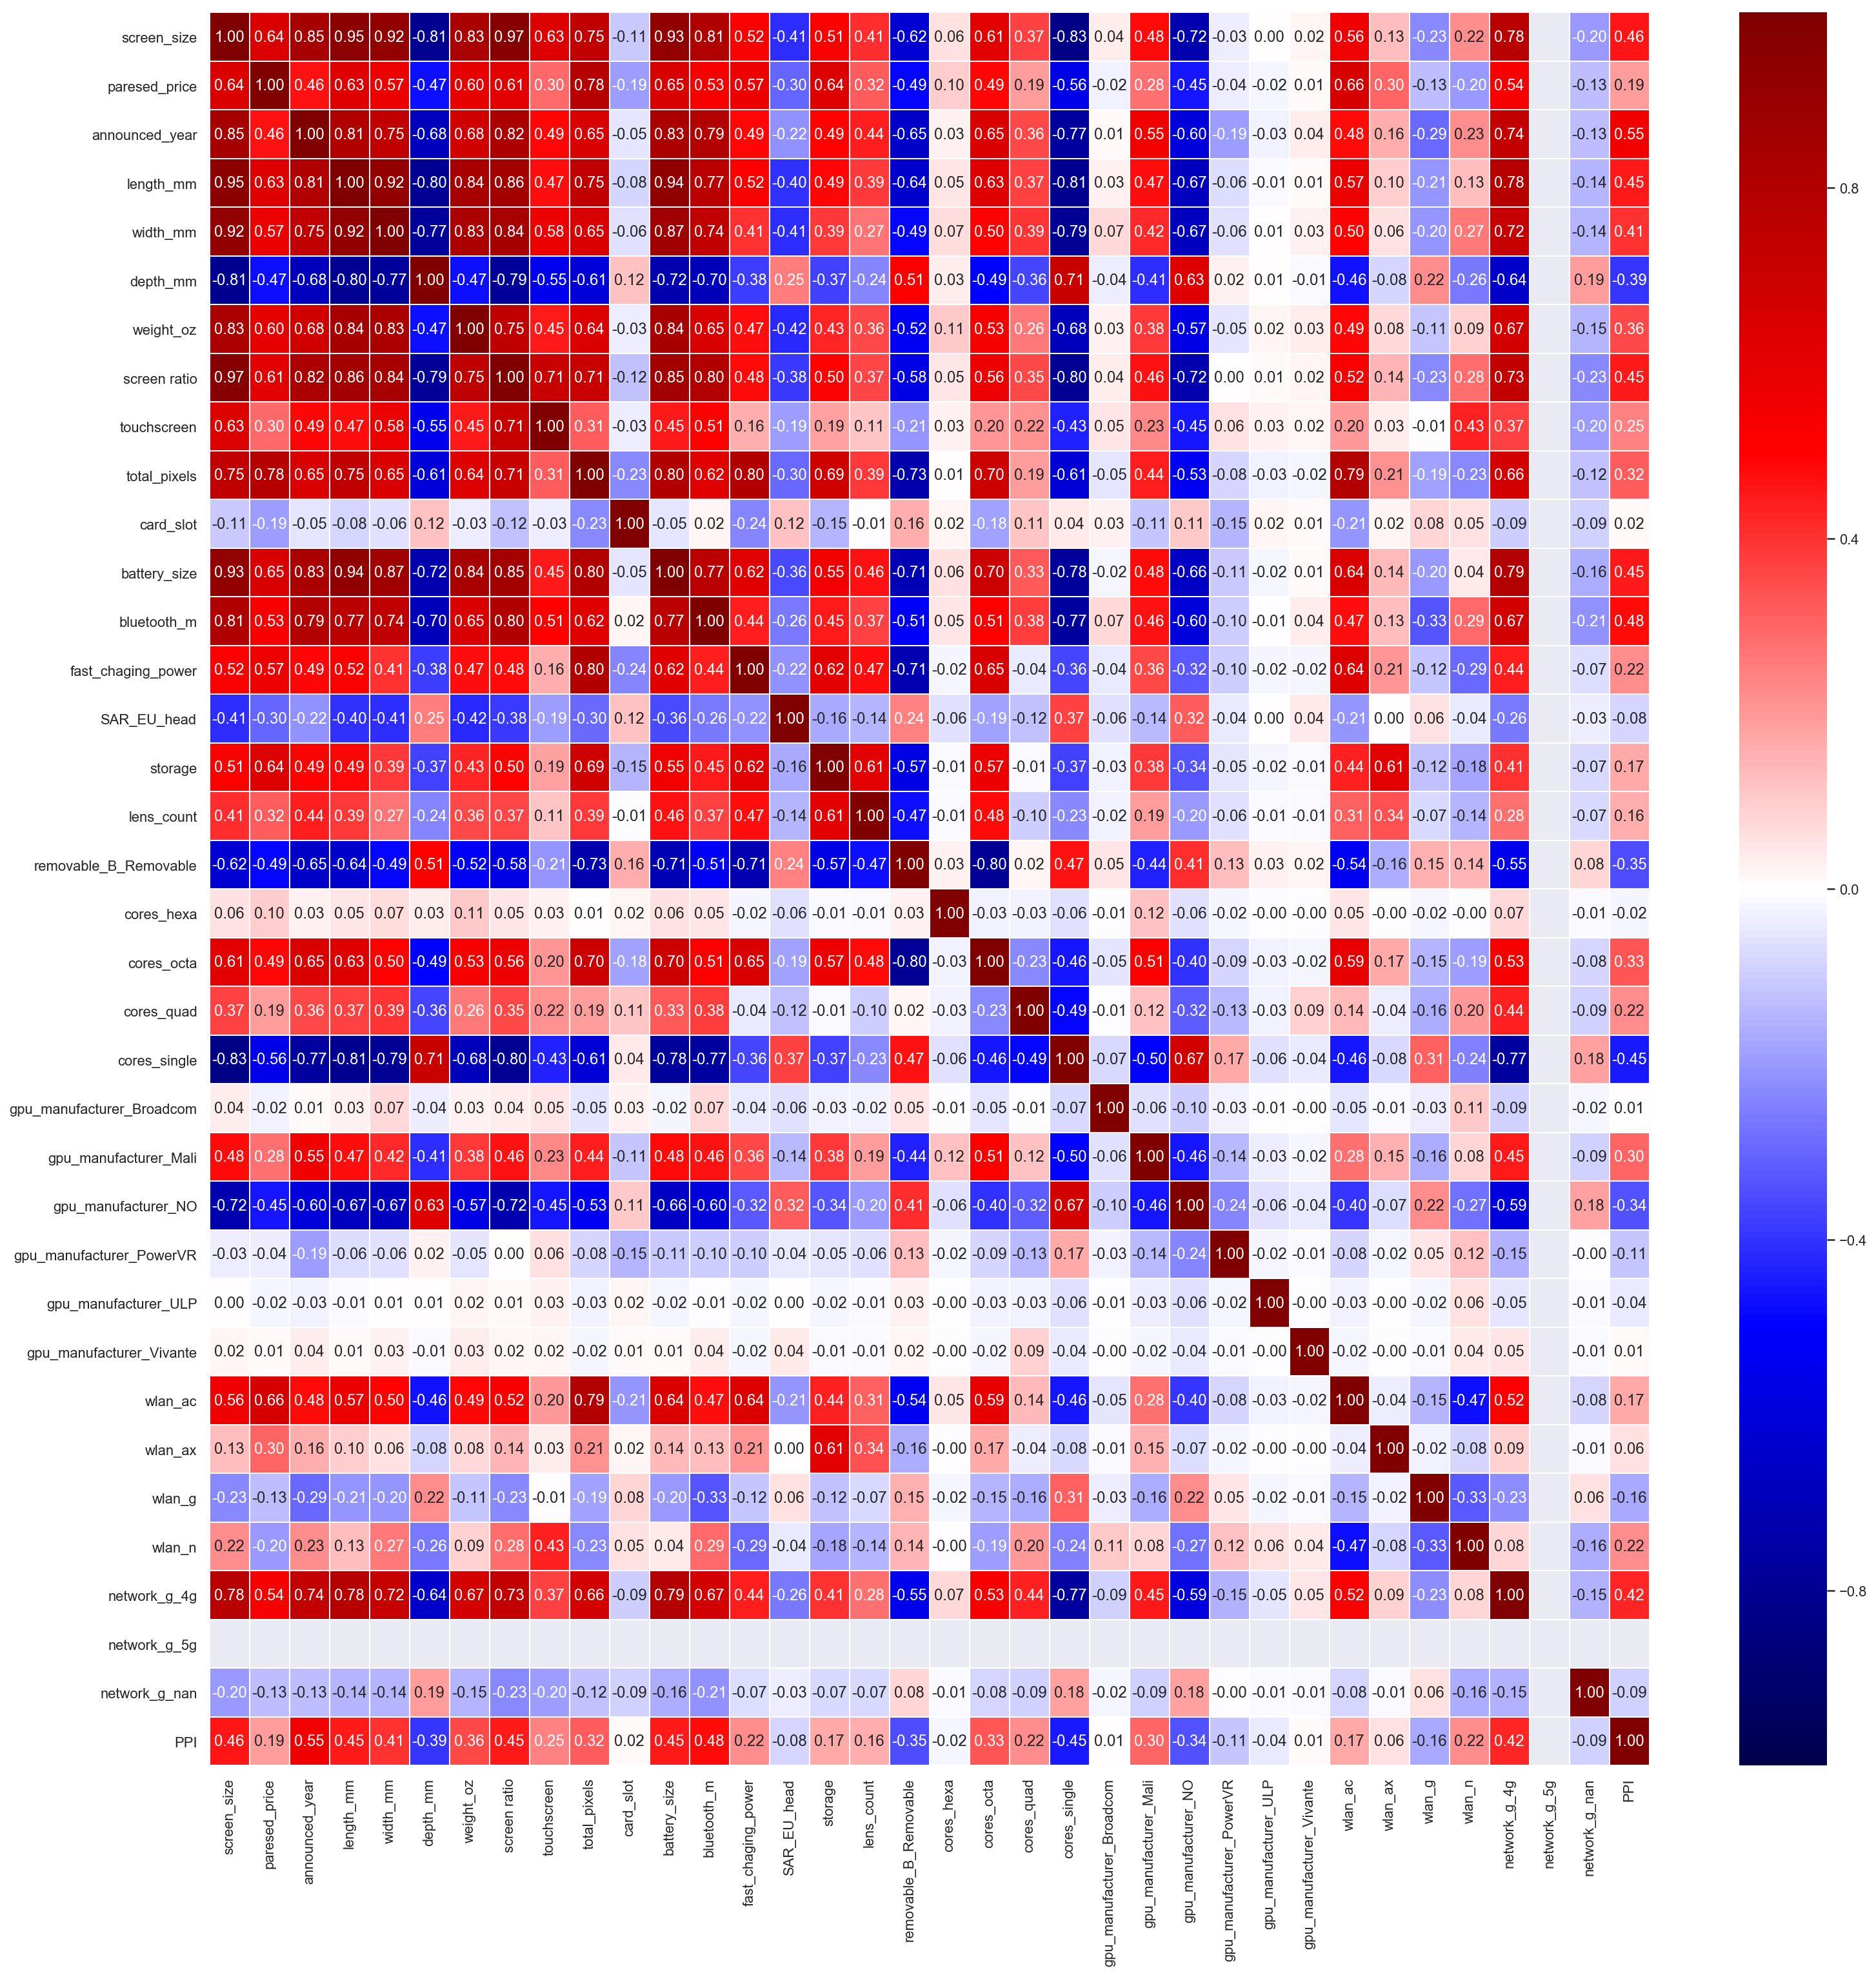

In [813]:
plt.figure(figsize=(25,25))
sns.heatmap(phones_df.corr(),fmt='.2f', linewidths=.5, cmap="seismic",annot=True, vmin=-1, vmax=1);
plt.savefig("initial_heatmap.eps")

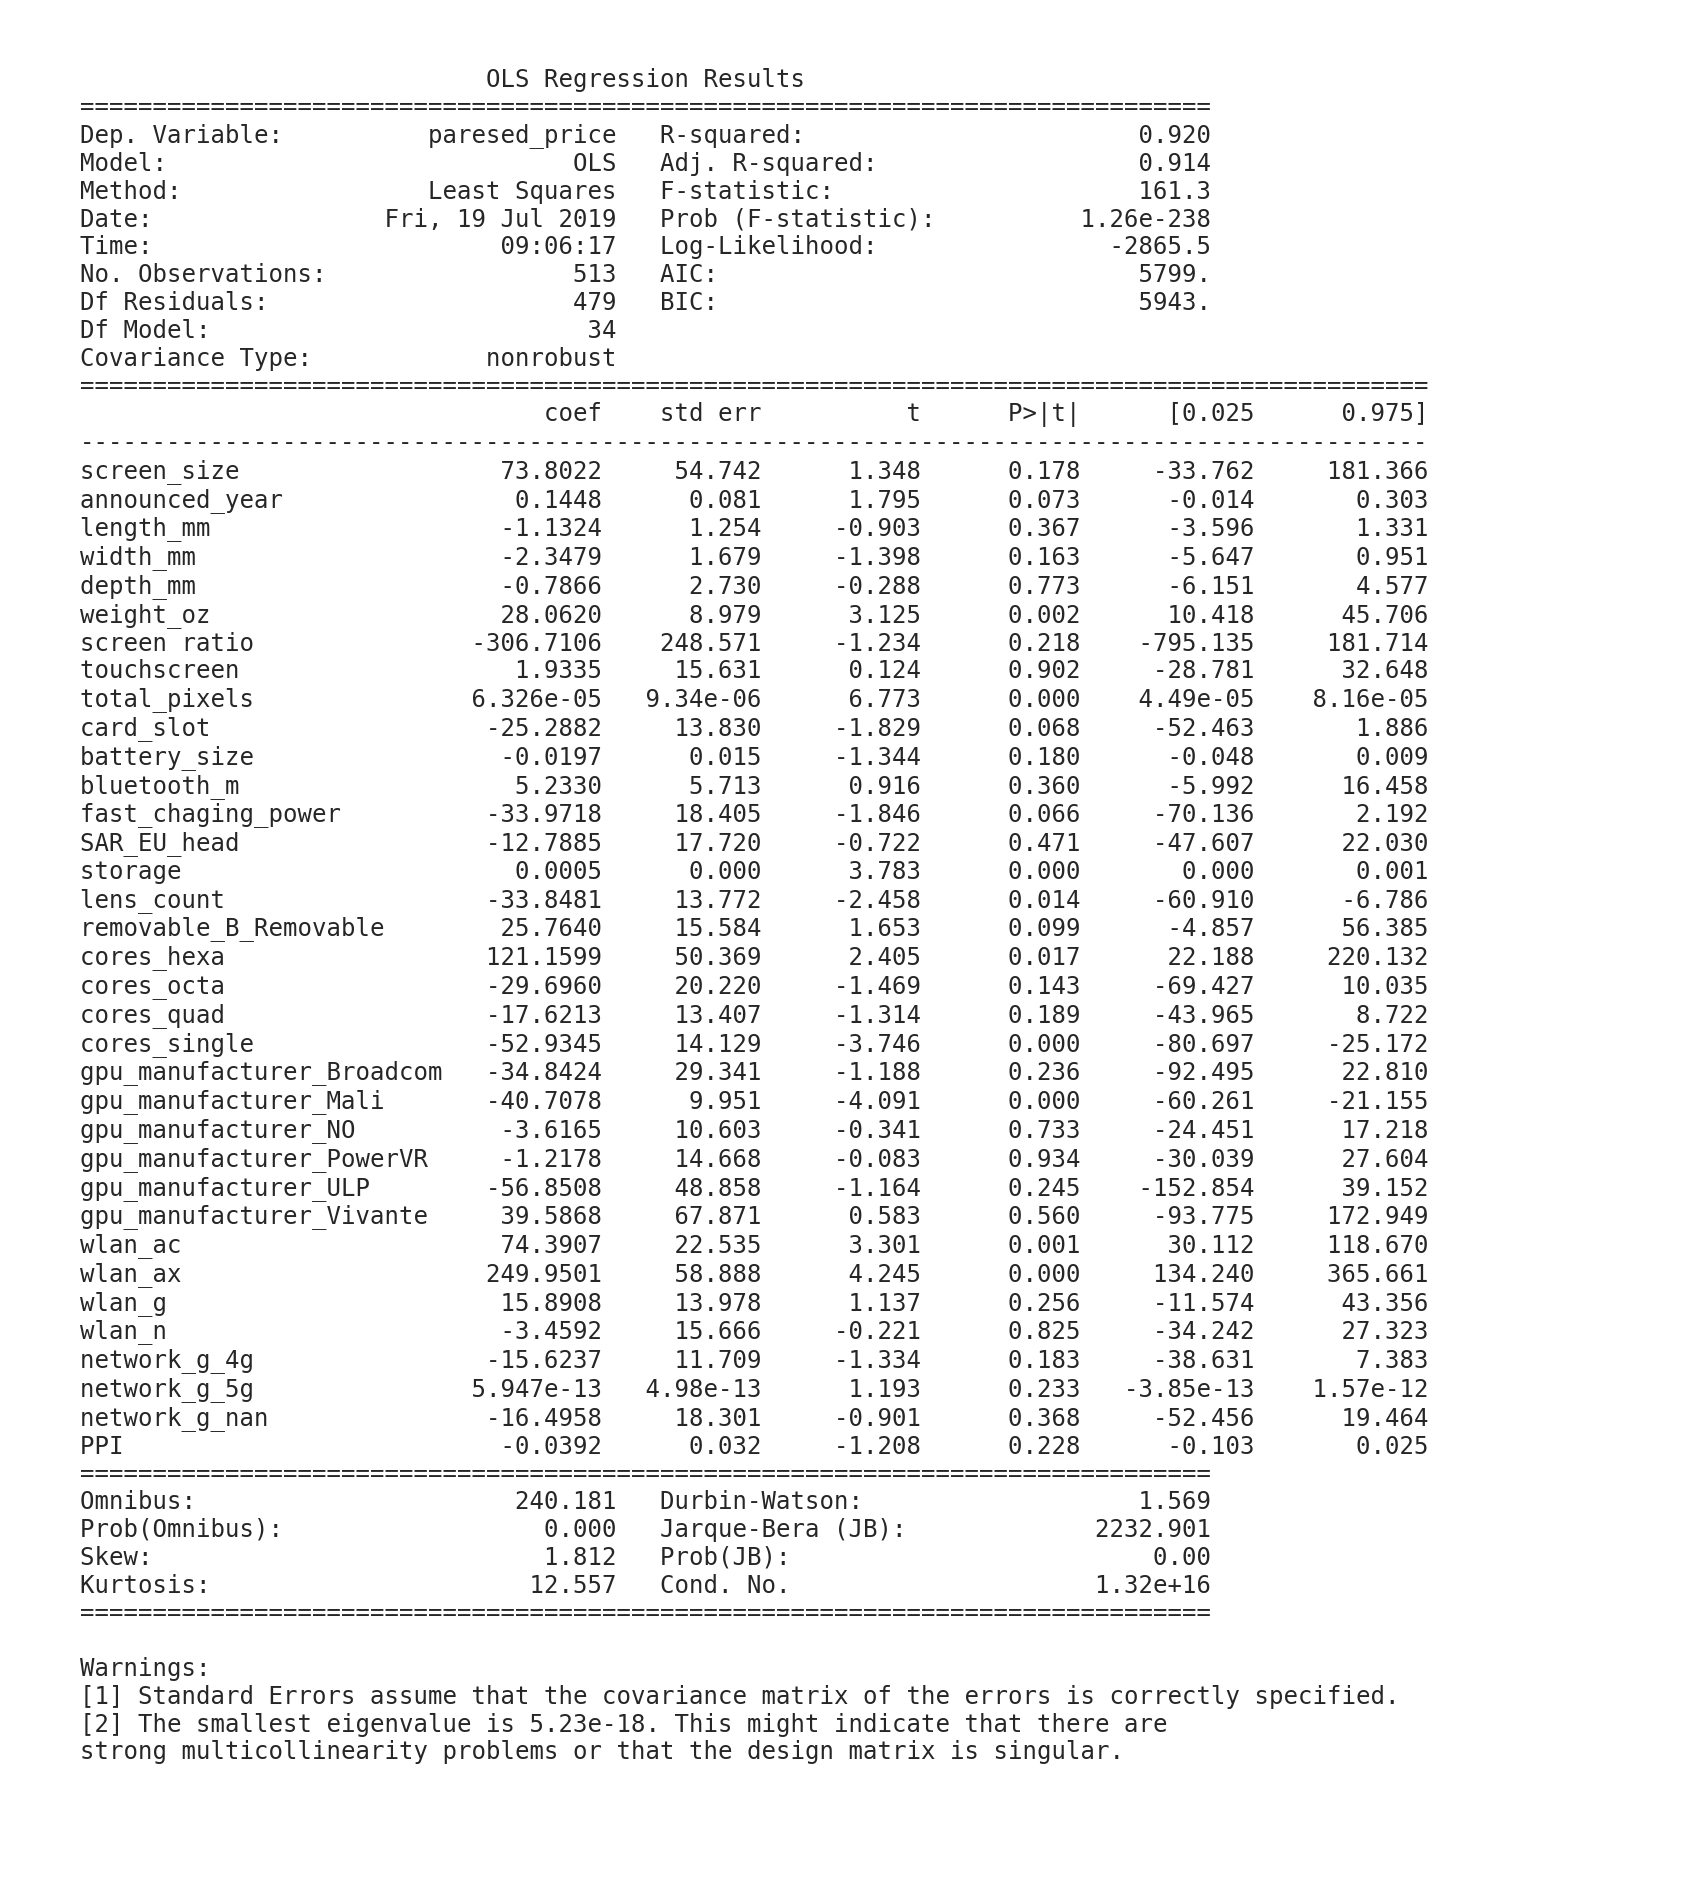

In [814]:
X = phones_df.loc[:,[x for x in phones_df if x not in  ["paresed_price"]]]
y  =  phones_df.loc[:,"paresed_price"]

model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

plt.rc('figure', figsize=(12, 15))
plt.text(0.01, 0.05, str(fit.summary()), {'fontsize': 10}, fontproperties = 'monospace') 
plt.axis('off')
plt.tight_layout()
plt.savefig('output1.eps')

In [815]:
a = split_and_validate(X,y)


Validation R^2 score was: 0.6819846917057042

Validation Adj R^2 score was: 0.515857291850475
Feature coefficient results: 

screen_size : 125.57
announced_year : -15.74
length_mm : -1.73
width_mm : -3.50
depth_mm : 3.01
weight_oz : 13.29
screen ratio : -511.99
touchscreen : 12.05
total_pixels : 0.00
card_slot : -20.26
battery_size : -0.01
bluetooth_m : 12.28
fast_chaging_power : -48.28
SAR_EU_head : 5.23
storage : 0.00
lens_count : -23.72
removable_B_Removable : 19.35
cores_hexa : 65.55
cores_octa : 18.30
cores_quad : 7.75
cores_single : -67.15
gpu_manufacturer_Broadcom : -20.33
gpu_manufacturer_Mali : -34.35
gpu_manufacturer_NO : -9.25
gpu_manufacturer_PowerVR : -27.34
gpu_manufacturer_ULP : -16.17
gpu_manufacturer_Vivante : 50.39
wlan_ac : 100.31
wlan_ax : 327.54
wlan_g : 32.16
wlan_n : 30.20
network_g_4g : -20.08
network_g_5g : -0.00
network_g_nan : 6.34
PPI : 0.05


In [816]:
phones_df['predict']=fit.predict(X)
phones_df['resid']=phones_df.paresed_price-phones_df.predict
phones_df["perc_error"] = phones_df['resid'].apply(abs)/phones_df.paresed_price
print("{}% is  the mean percentage ereor".format(round(100*phones_df["perc_error"].mean(),2)))
phones_df.drop(columns= ["perc_error"],inplace=True)

26.15% is  the mean percentage ereor


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


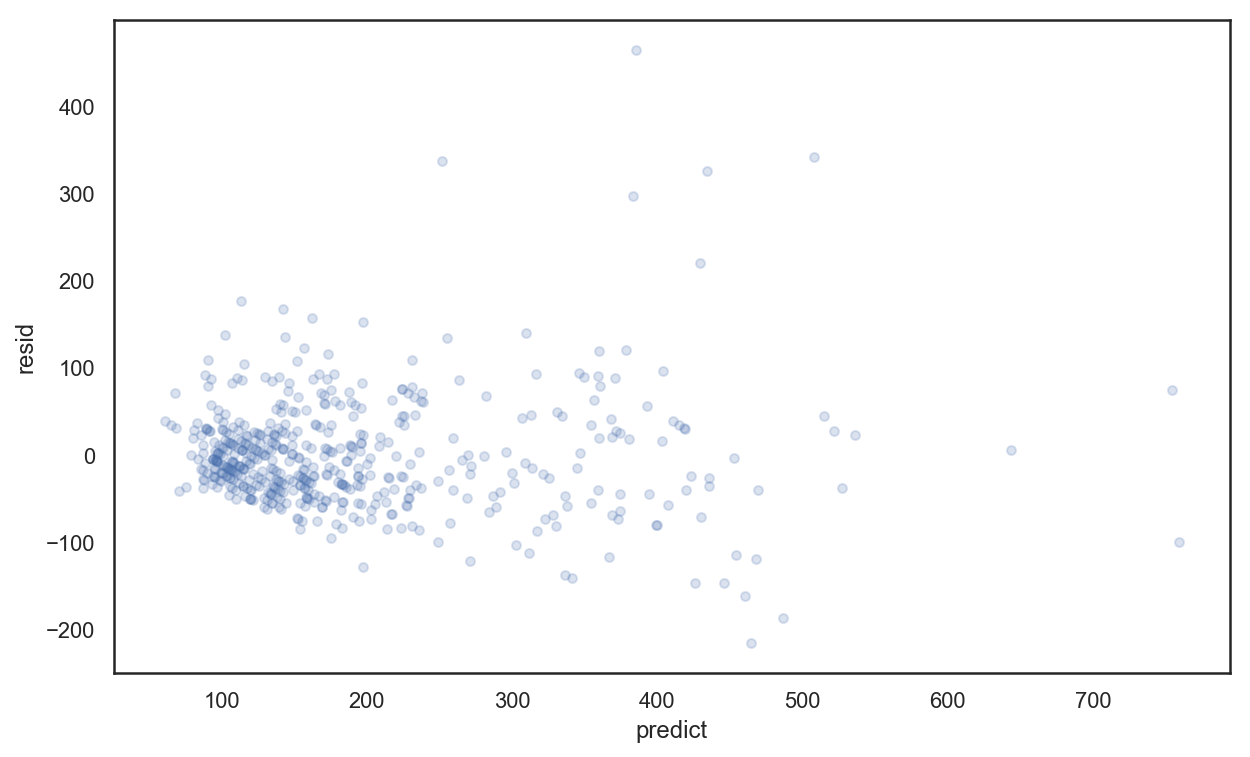

In [817]:

with sns.axes_style('white'):
    plot=phones_df.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))
plt.savefig("1st_resedual.eps");

In [818]:
(phones_df.drop(columns=[x for x in phones_df.columns if x[:3] == "gpu"]+
                [x for x in phones_df.columns if x[:8] == "network_"]
                +["predict","resid"],inplace=True))

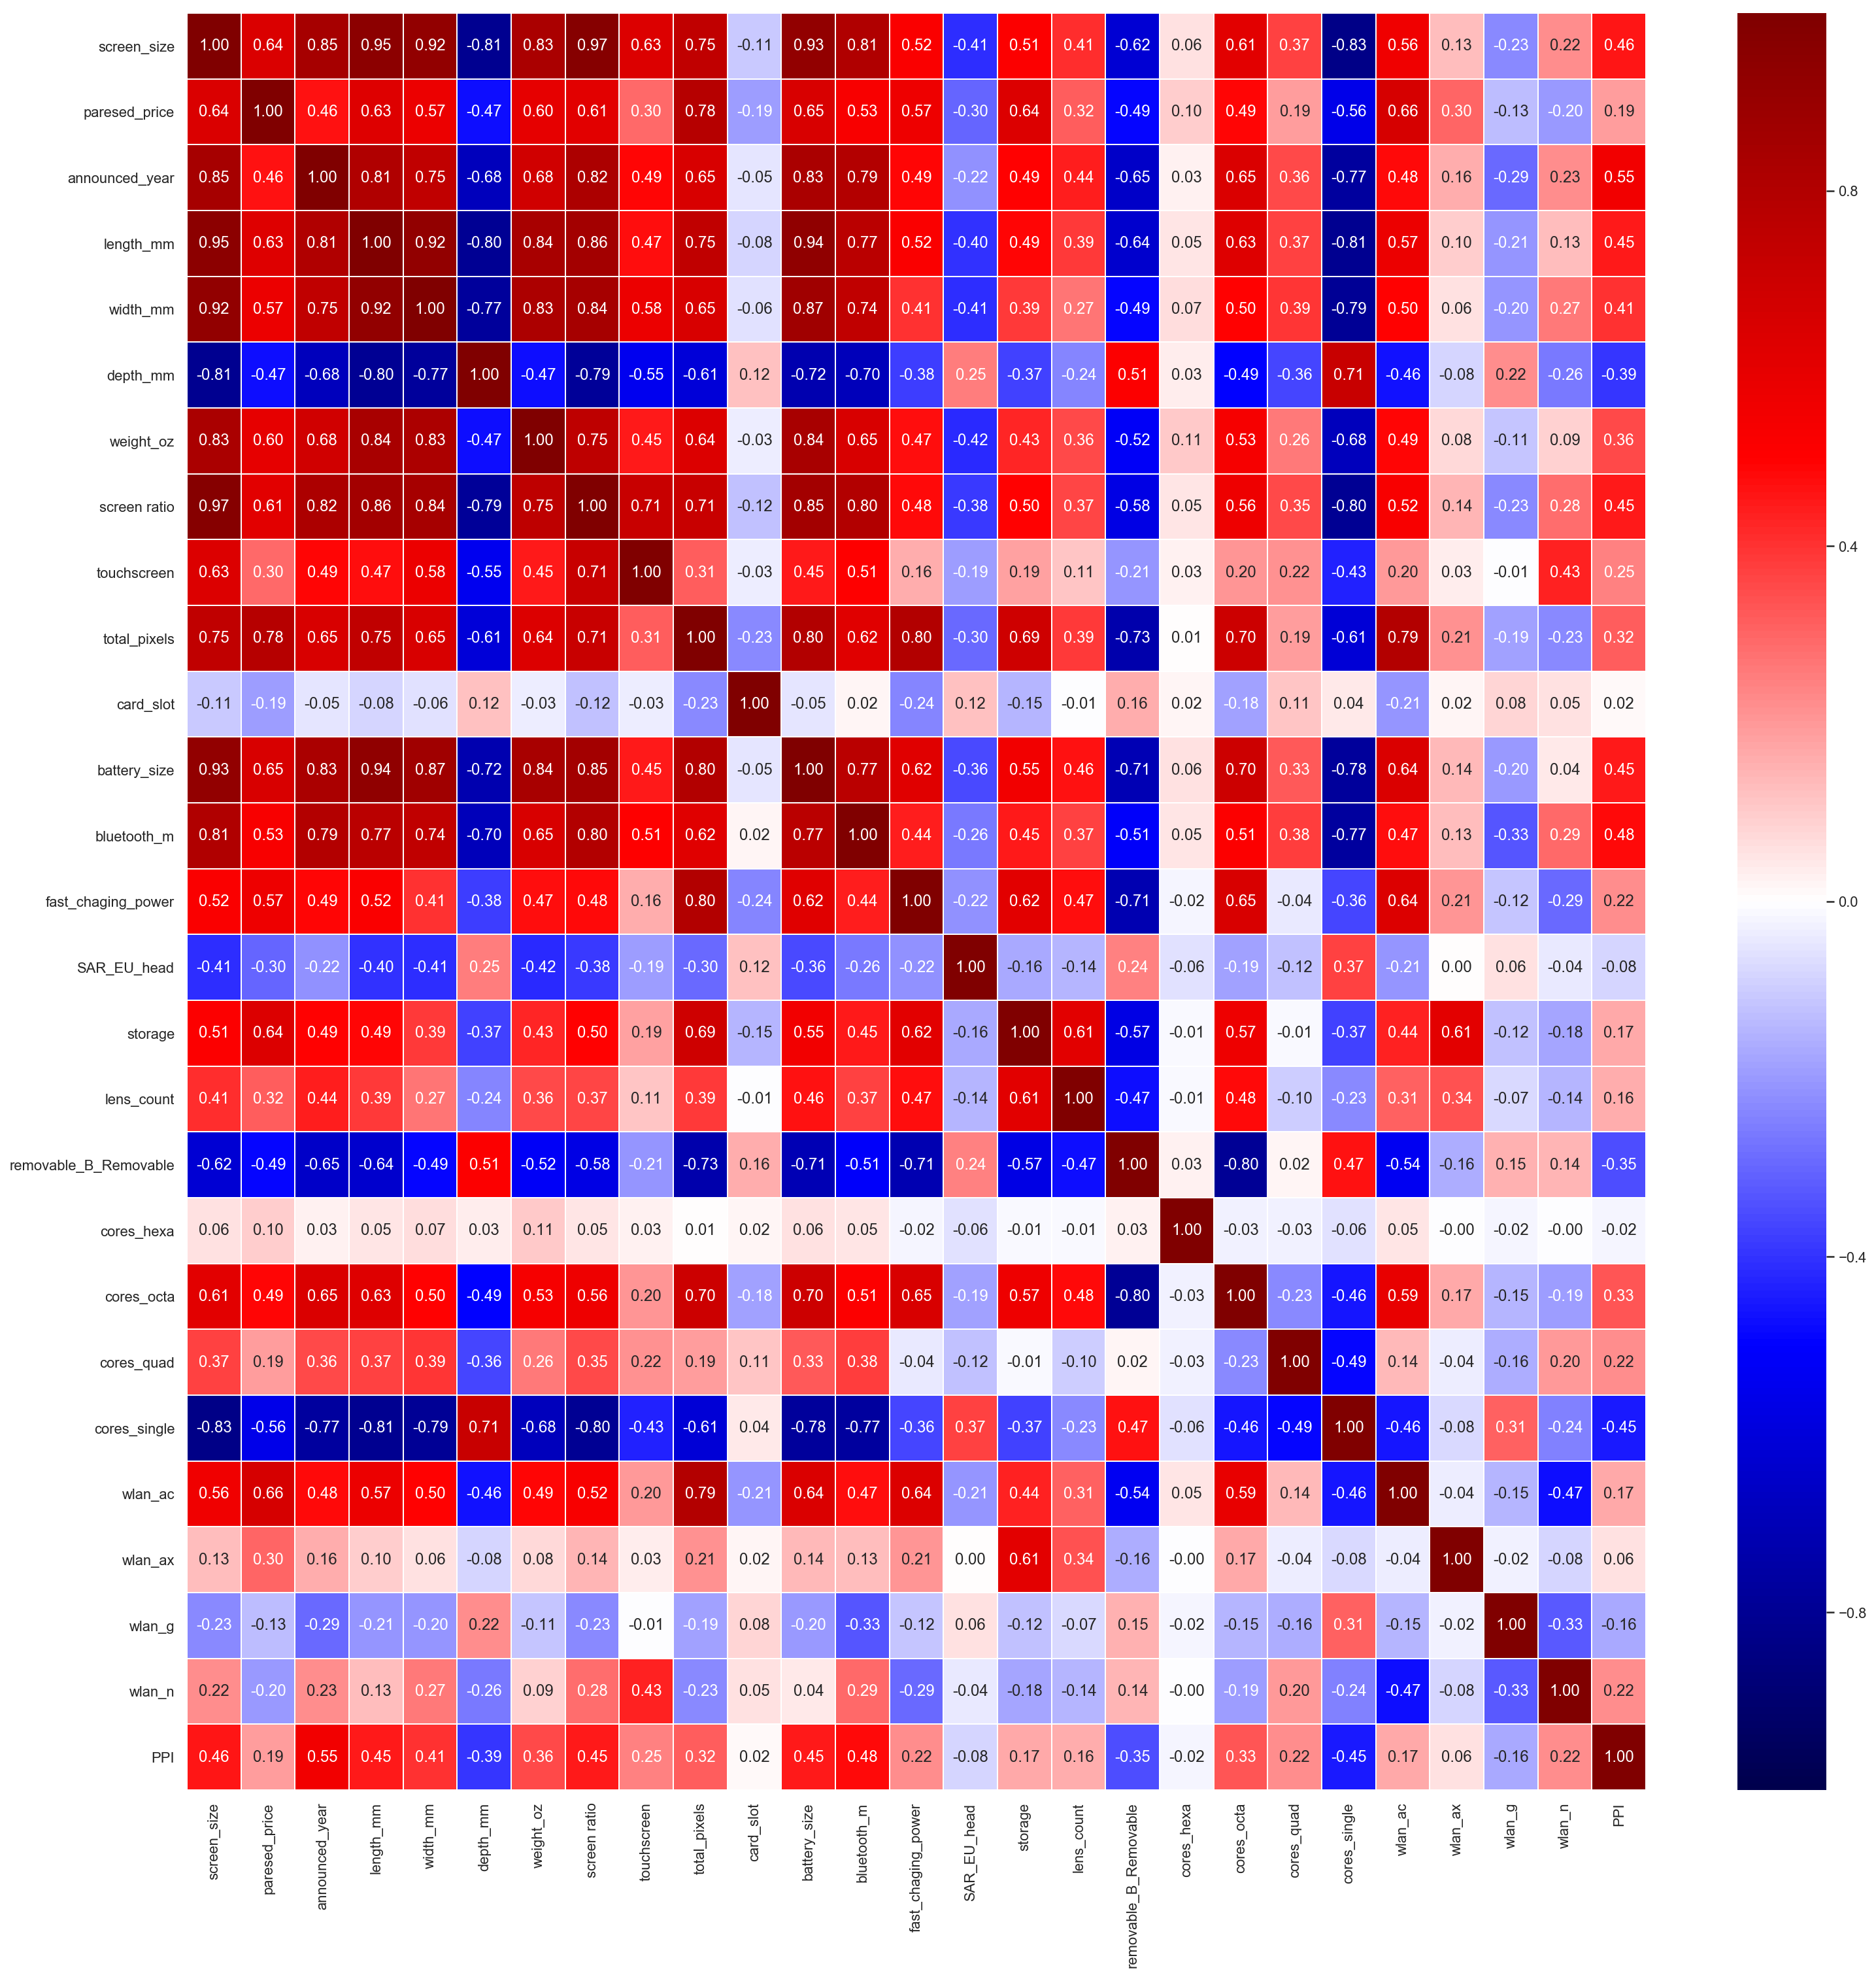

In [819]:
plt.figure(figsize=(25,25))
(sns.heatmap(phones_df.corr(),fmt='.2f', linewidths=.5, cmap="seismic",annot=True, vmin=-1, vmax=1));

plt.savefig("2nd_heatmap.eps")

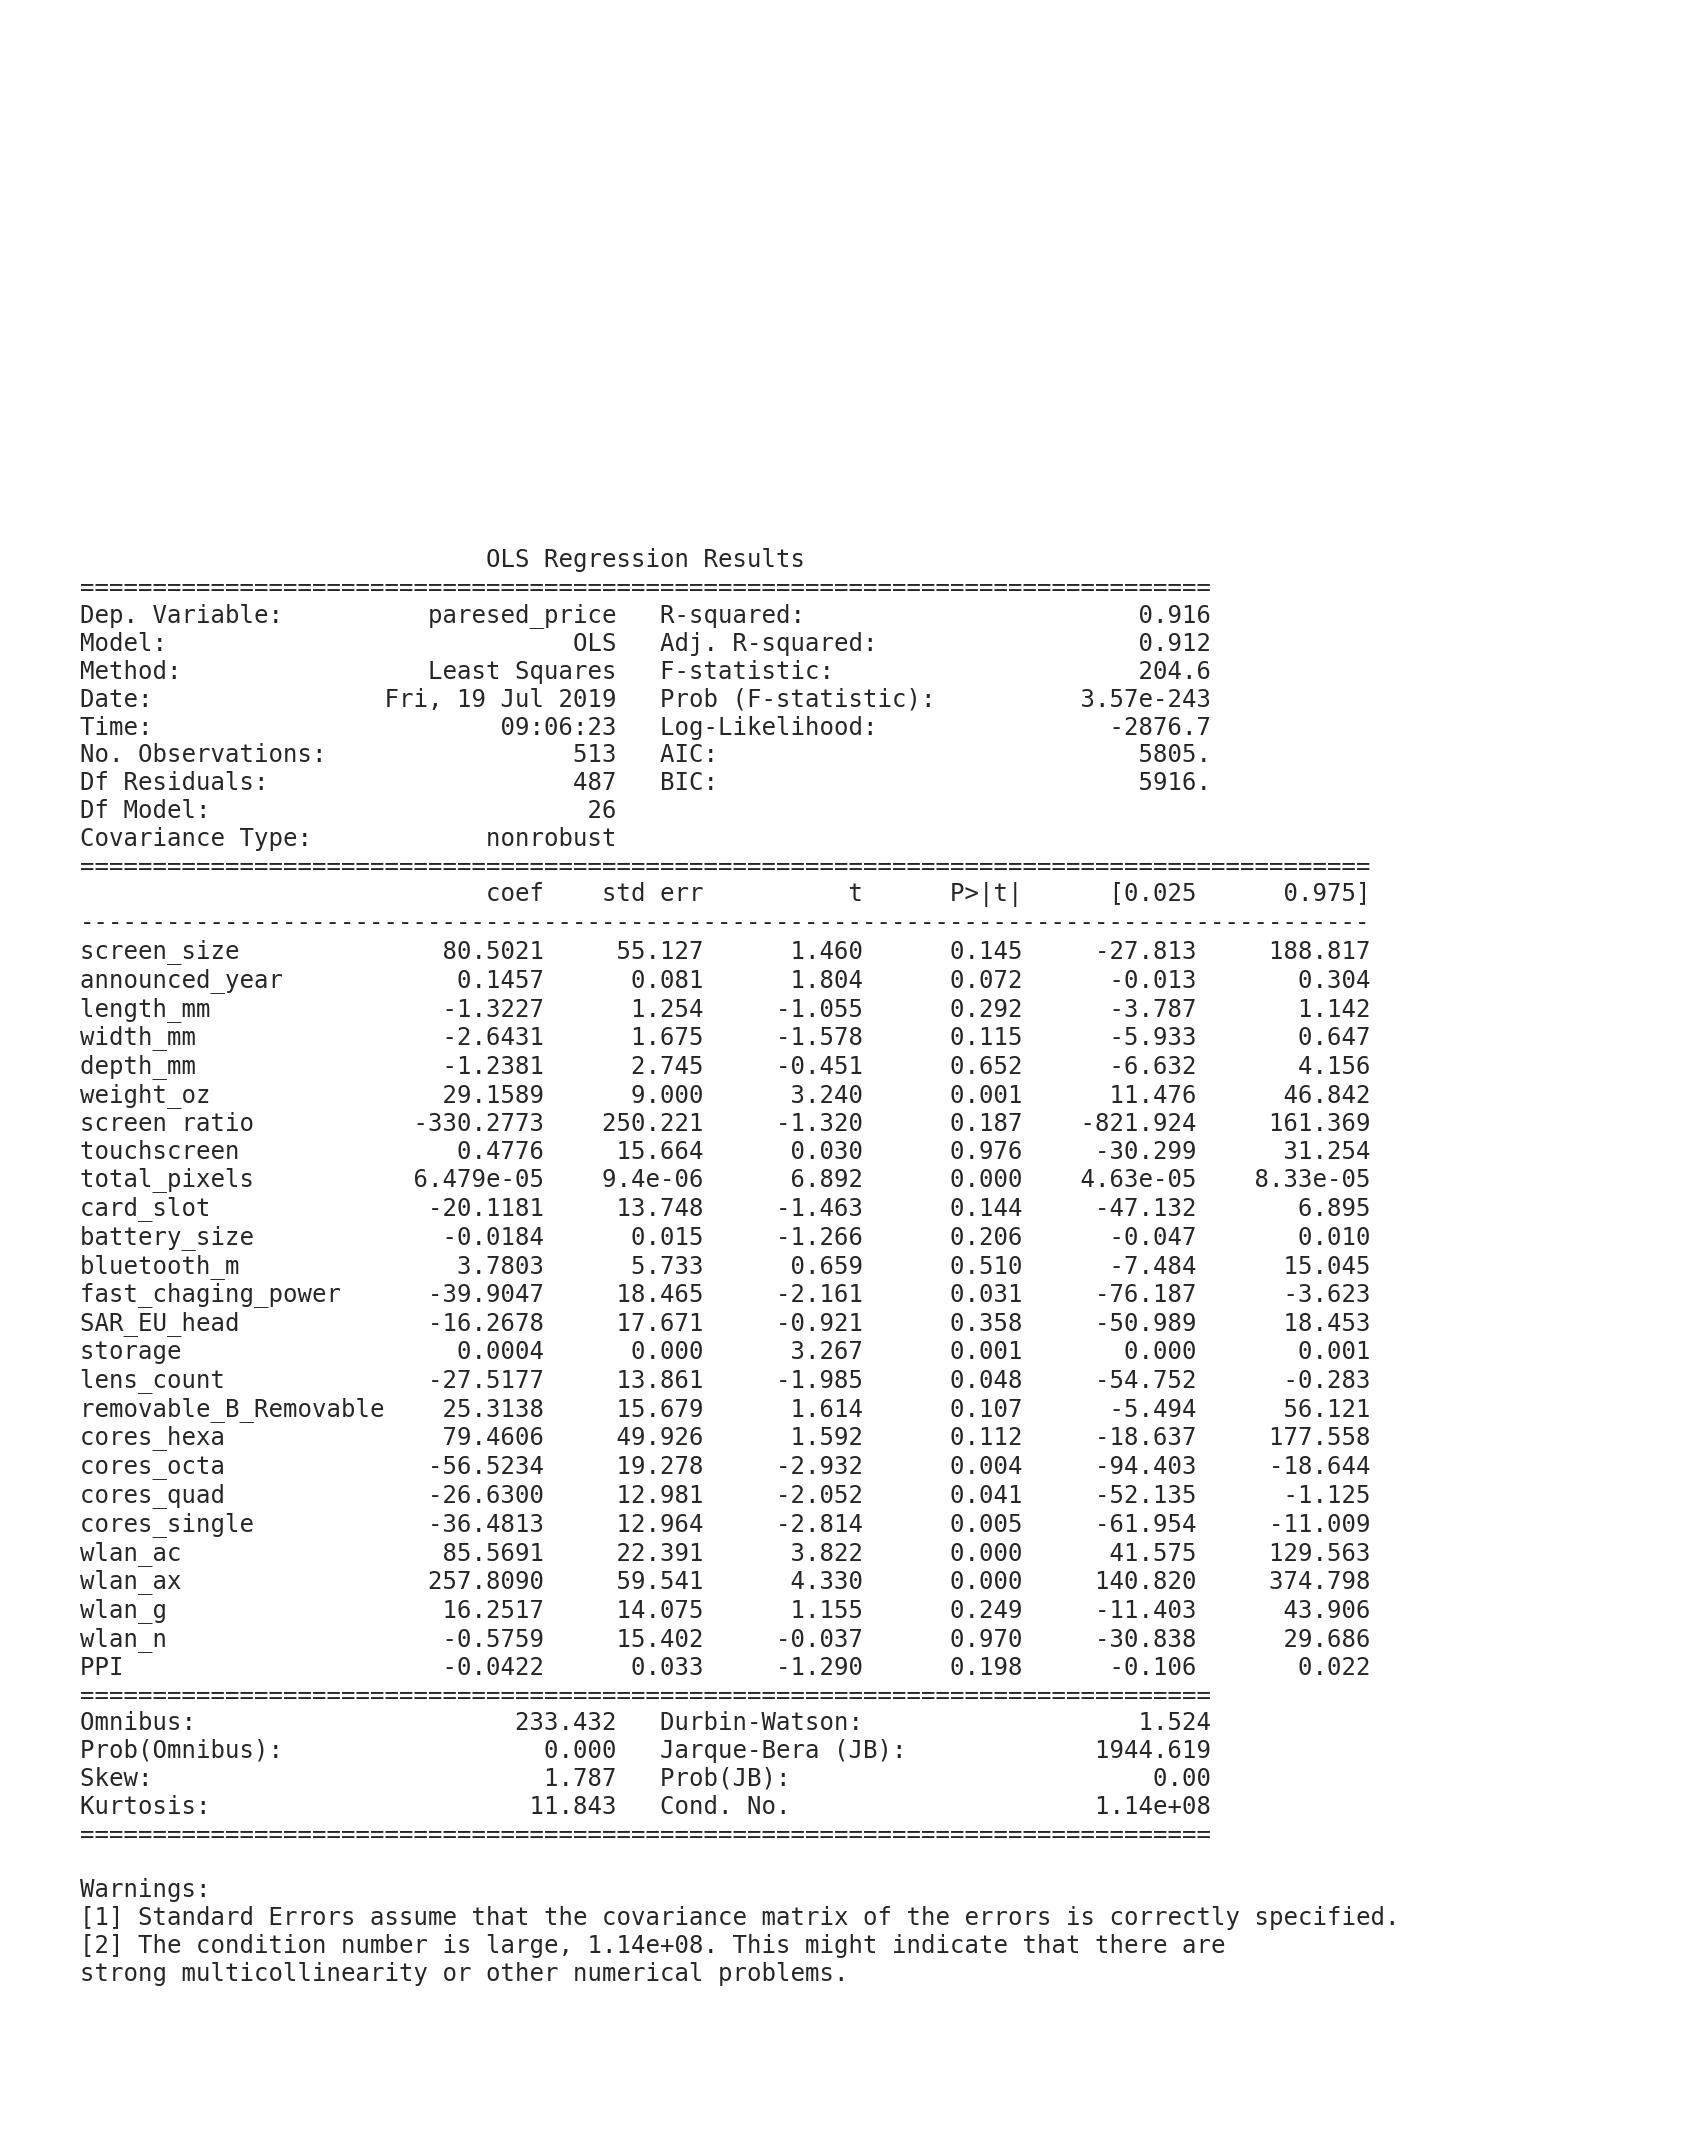

In [820]:
X = phones_df.loc[:,[x for x in phones_df if x not in  ["paresed_price",'predict','resid']]]
y  =  phones_df.loc[:,"paresed_price"]

model = sm.OLS(y, X)

fit = model.fit()

fit.summary()

plt.rc('figure', figsize=(12, 15))
plt.text(0.01, 0.05, str(fit.summary()), {'fontsize': 10}, fontproperties = 'monospace') 
plt.axis('off')
plt.tight_layout()
plt.savefig('output2.eps')

In [821]:
a = split_and_validate(X,y)


Validation R^2 score was: 0.6758649672851142

Validation Adj R^2 score was: 0.5649766666194954
Feature coefficient results: 

screen_size : 128.59
announced_year : -16.06
length_mm : -1.95
width_mm : -3.26
depth_mm : 3.08
weight_oz : 12.63
screen ratio : -543.65
touchscreen : 13.04
total_pixels : 0.00
card_slot : -12.88
battery_size : -0.01
bluetooth_m : 11.27
fast_chaging_power : -54.27
SAR_EU_head : -0.42
storage : 0.00
lens_count : -20.55
removable_B_Removable : 17.60
cores_hexa : 28.61
cores_octa : -1.39
cores_quad : 2.80
cores_single : -60.07
wlan_ac : 103.71
wlan_ax : 332.27
wlan_g : 31.76
wlan_n : 29.46
PPI : 0.04


In [822]:
phones_df['predict']=fit.predict(X)
phones_df['resid']=phones_df.paresed_price-phones_df.predict
phones_df["perc_error"] = phones_df['resid'].apply(abs)/phones_df.paresed_price
print("{}% is  the mean percentage ereor".format(round(100*phones_df["perc_error"].mean(),2)))
phones_df.drop(columns= ["perc_error"],inplace=True)

27.01% is  the mean percentage ereor


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


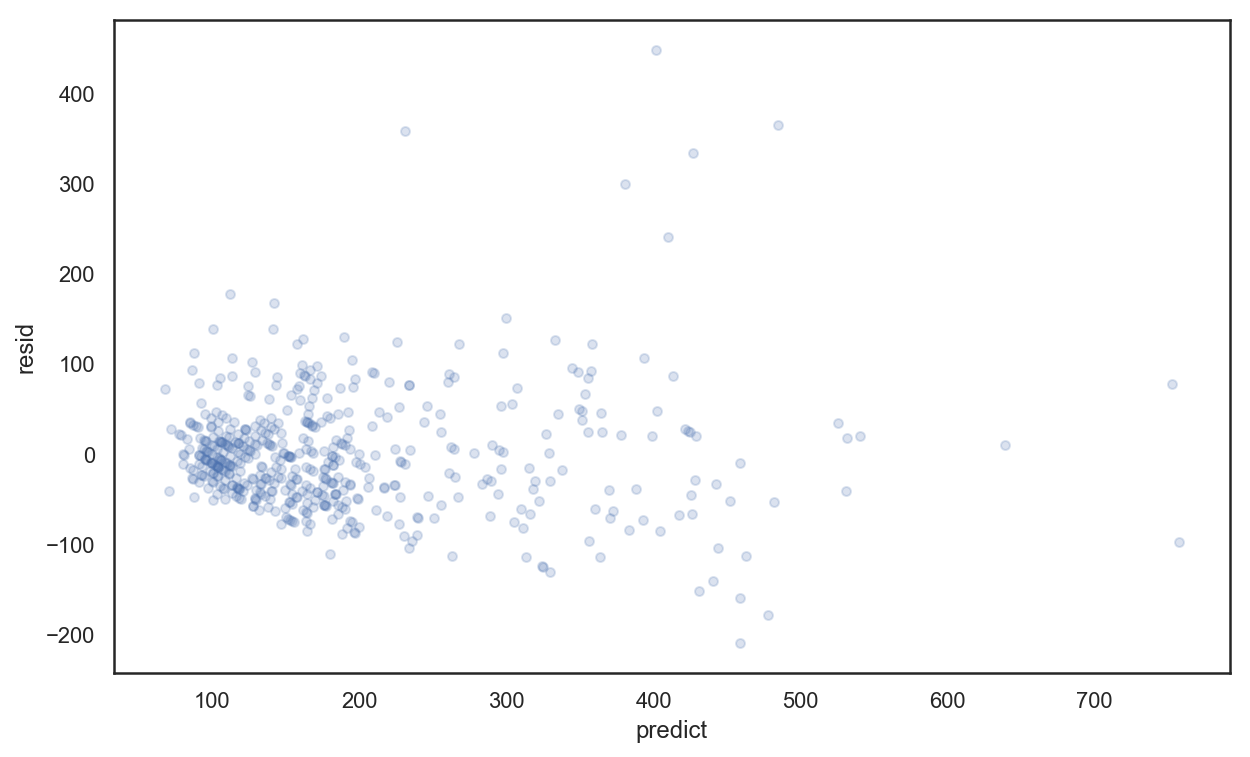

In [823]:

with sns.axes_style('white'):
    plot=phones_df.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))
plt.savefig("2nd_resedual.eps");

In [824]:
phones_df.drop(columns=["weight_oz","card_slot","announced_year","length_mm","width_mm","touchscreen","screen ratio","battery_size","total_pixels","bluetooth_m"],inplace=True)

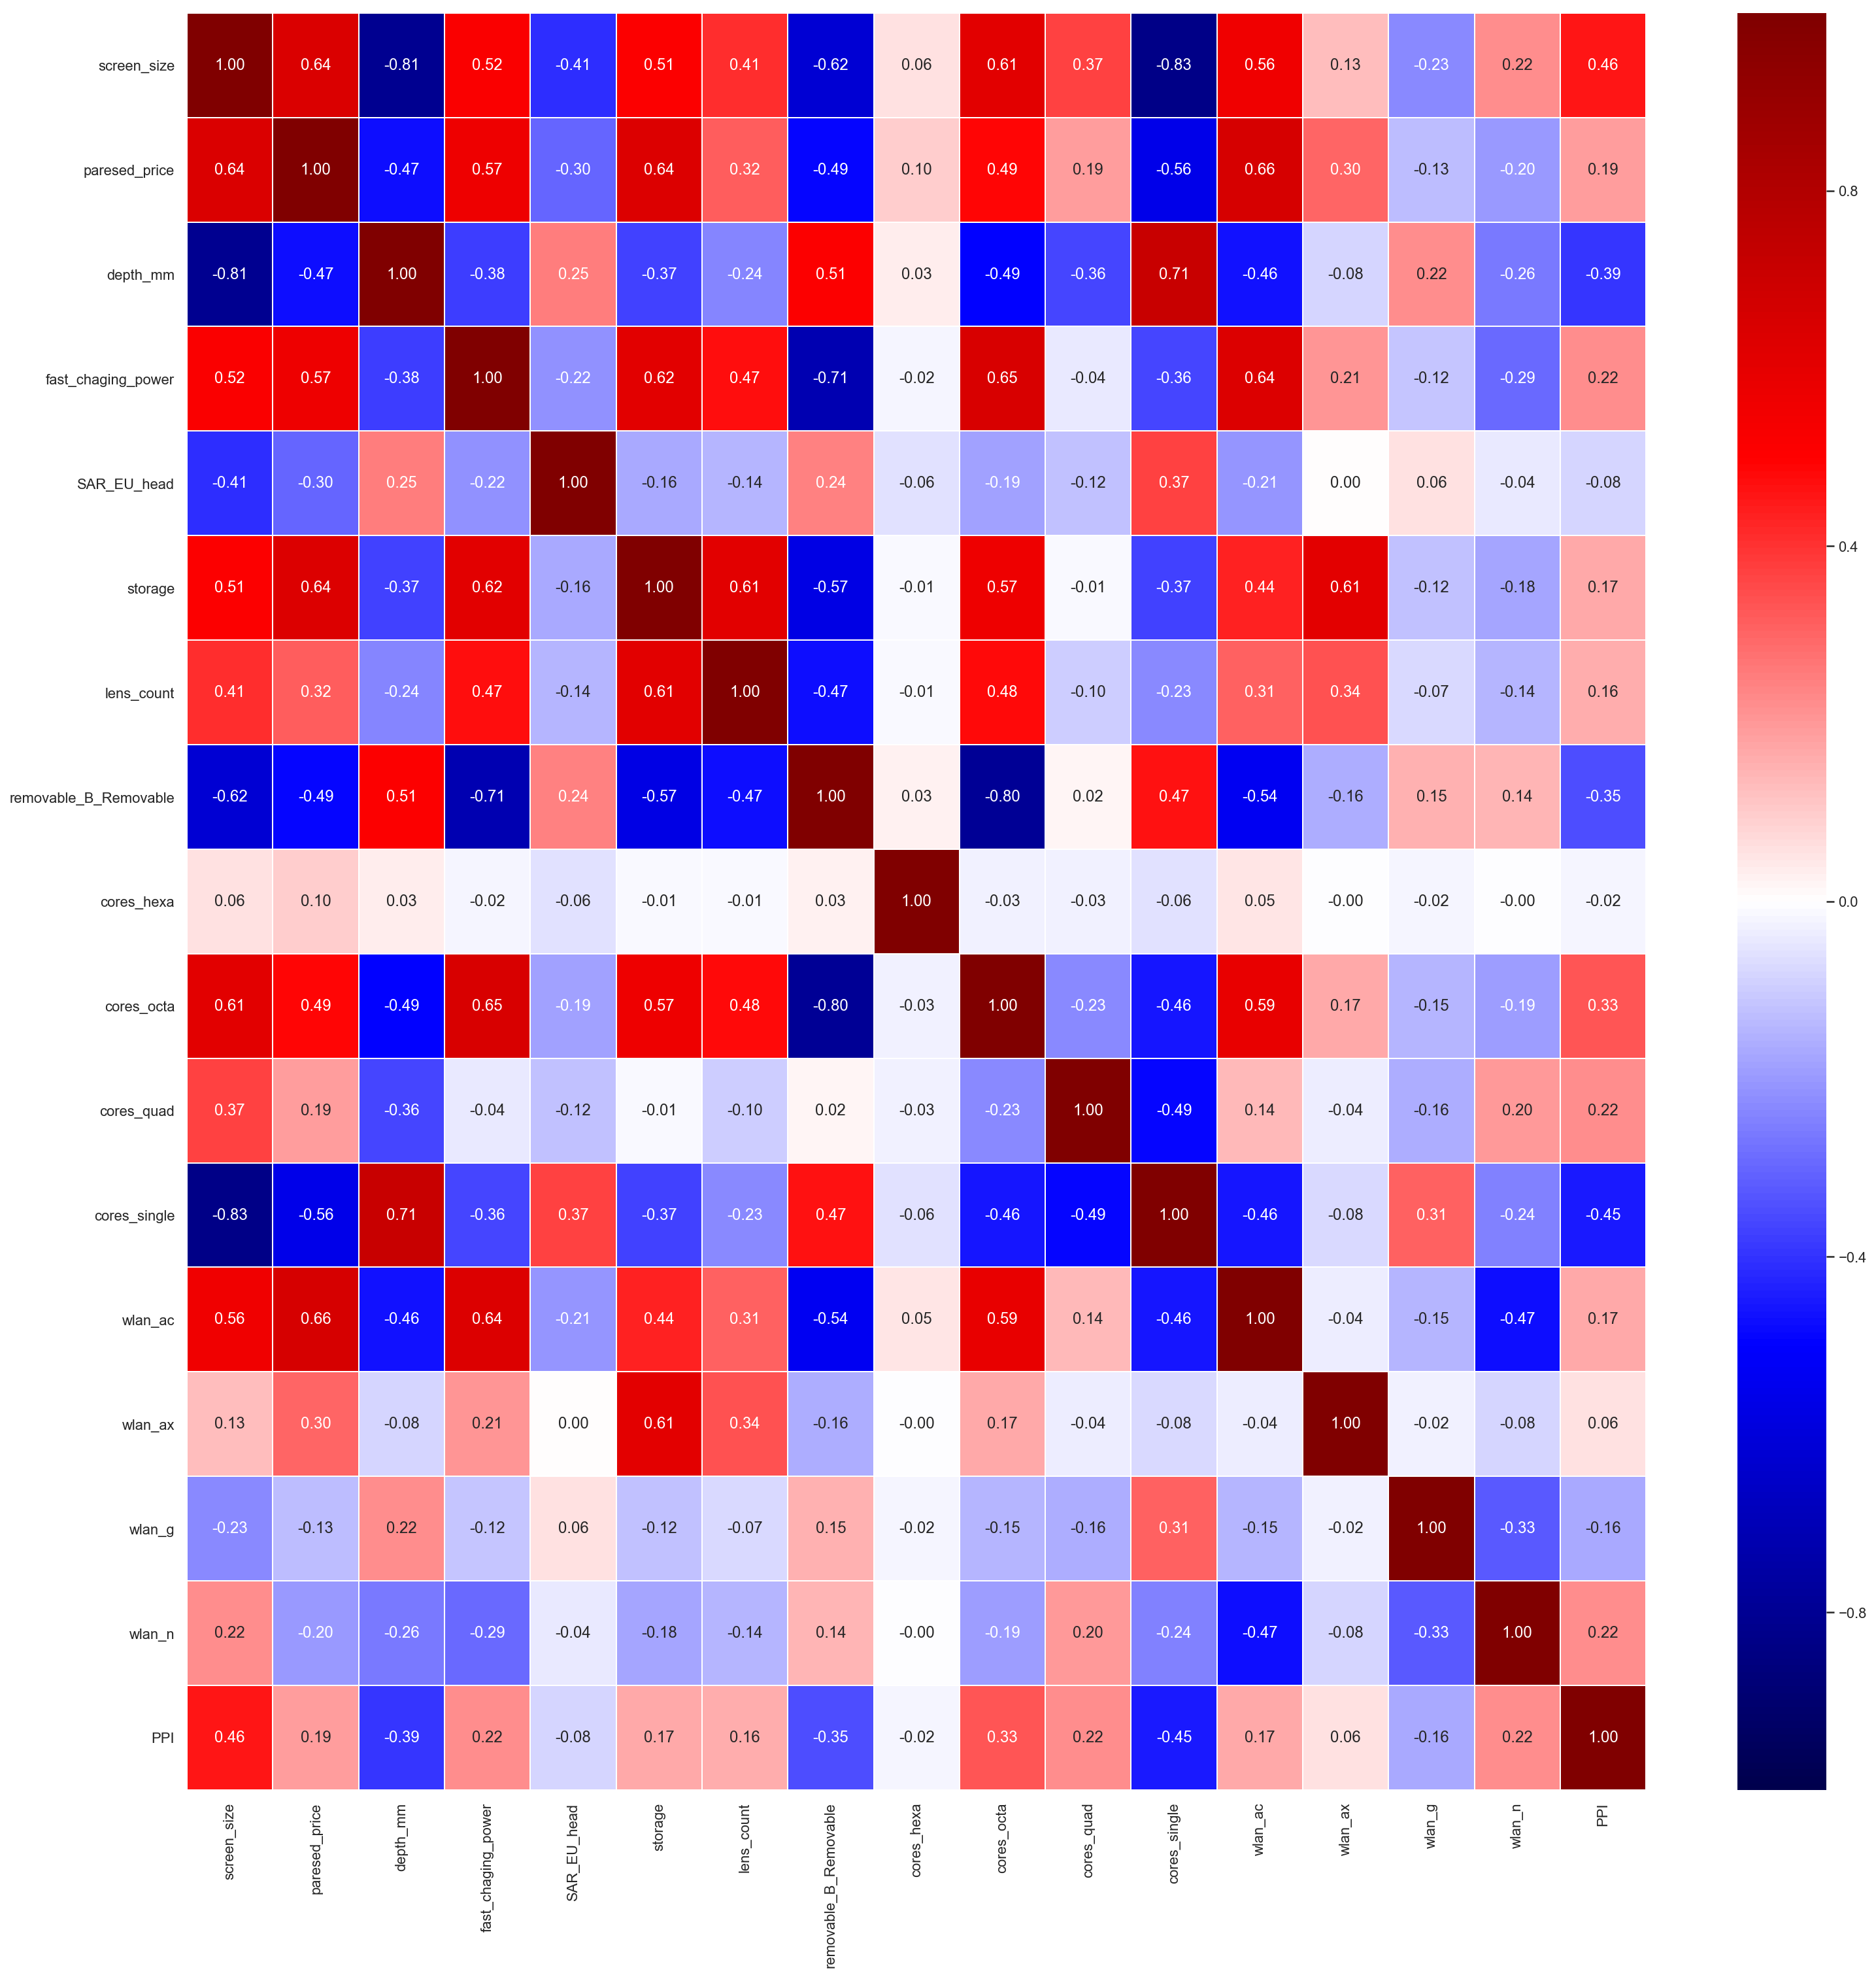

In [825]:
phones_df.drop(columns =["predict","resid"],inplace=True)
plt.figure(figsize=(25,25))
(sns.heatmap(phones_df.corr(),fmt='.2f', linewidths=.5, cmap="seismic",annot=True, vmin=-1, vmax=1));

plt.savefig("3rd_heatmap.eps")

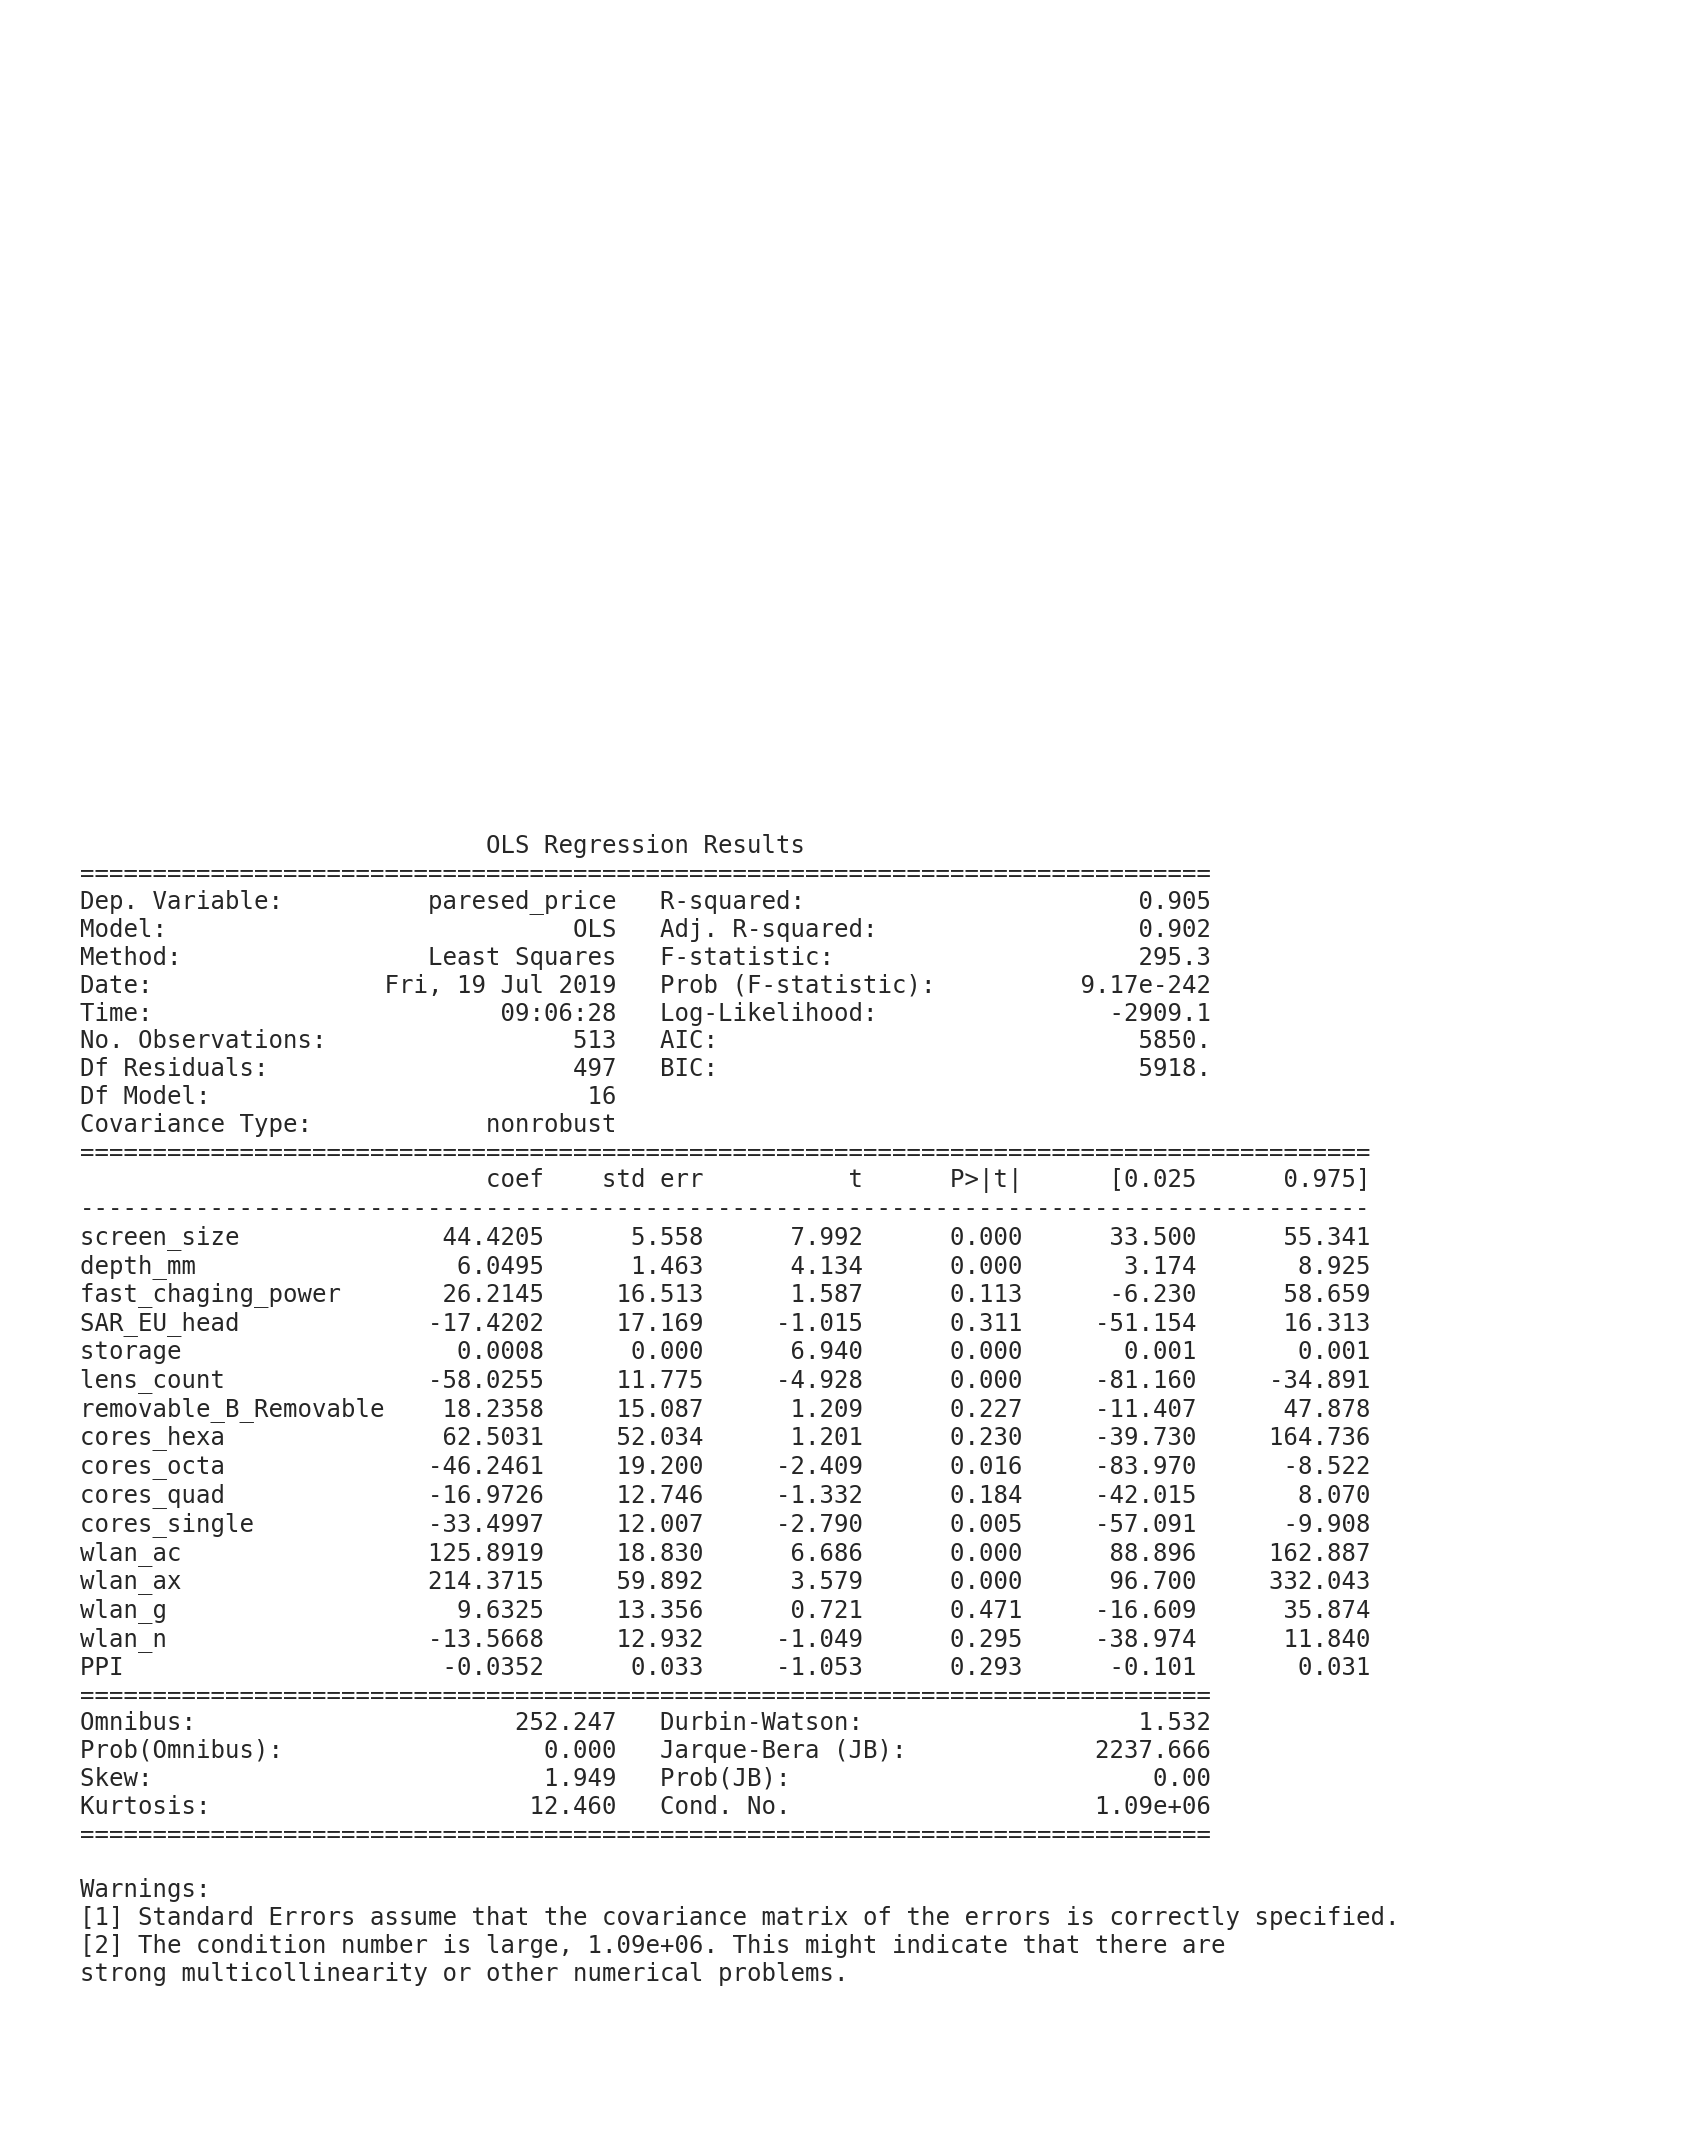

In [826]:
X = phones_df.loc[:,[x for x in phones_df if x not in  ["paresed_price",'predict','resid']]]
y  =  phones_df.loc[:,"paresed_price"]

model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 15))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(fit.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('output3.png')

In [827]:
a = split_and_validate(X,y)


Validation R^2 score was: 0.6786797067813914

Validation Adj R^2 score was: 0.6188991871128131
Feature coefficient results: 

screen_size : 29.84
depth_mm : 4.23
fast_chaging_power : 11.38
SAR_EU_head : -17.61
storage : 0.00
lens_count : -63.26
removable_B_Removable : 19.76
cores_hexa : -47.70
cores_octa : -35.86
cores_quad : -16.48
cores_single : -45.51
wlan_ac : 132.59
wlan_ax : 203.38
wlan_g : 19.23
wlan_n : -4.21
PPI : -0.01


In [828]:
phones_df['predict']=fit.predict(X)
phones_df['resid']=phones_df.paresed_price-phones_df.predict
phones_df["perc_error"] = phones_df['resid'].apply(abs)/phones_df.paresed_price
print("{}% is  the mean percentage ereor".format(round(100*phones_df["perc_error"].mean(),2)))
phones_df.drop(columns= ["perc_error"],inplace=True)

29.14% is  the mean percentage ereor


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


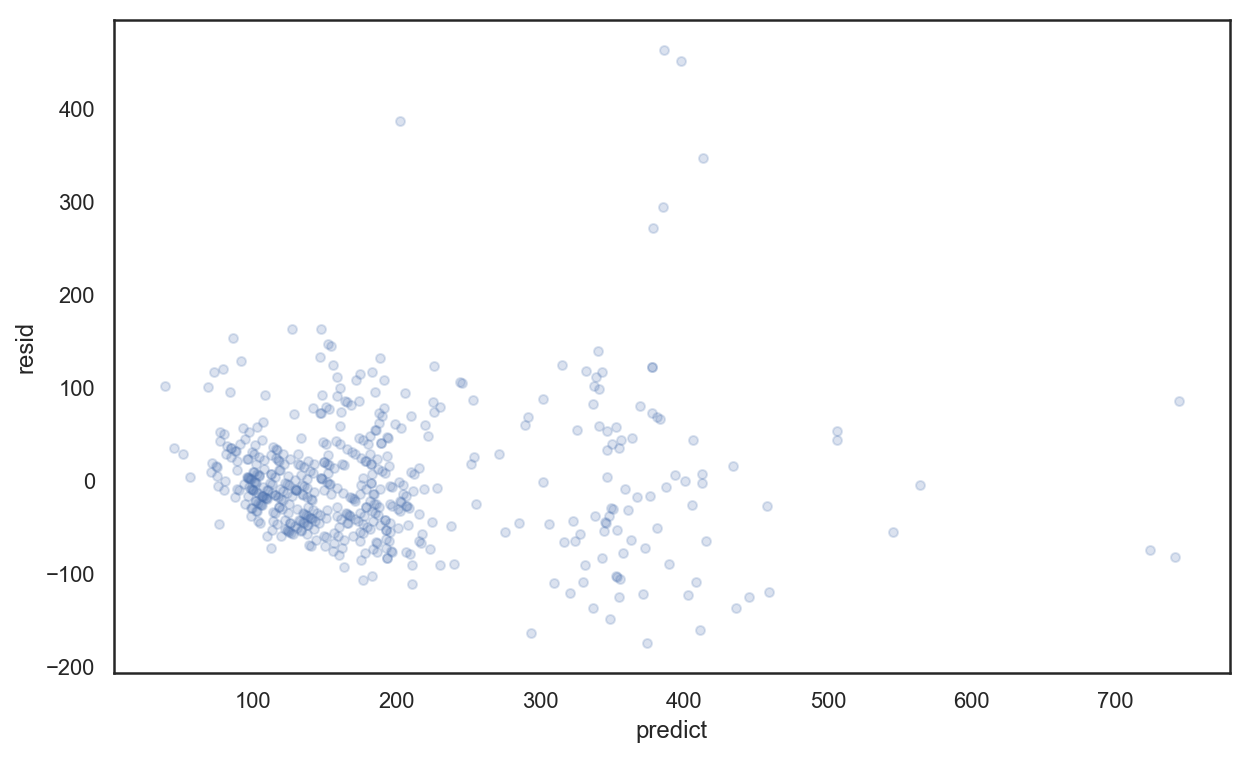

In [829]:

with sns.axes_style('white'):
    plot=phones_df.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))
plt.savefig("3rd_resedual.eps");

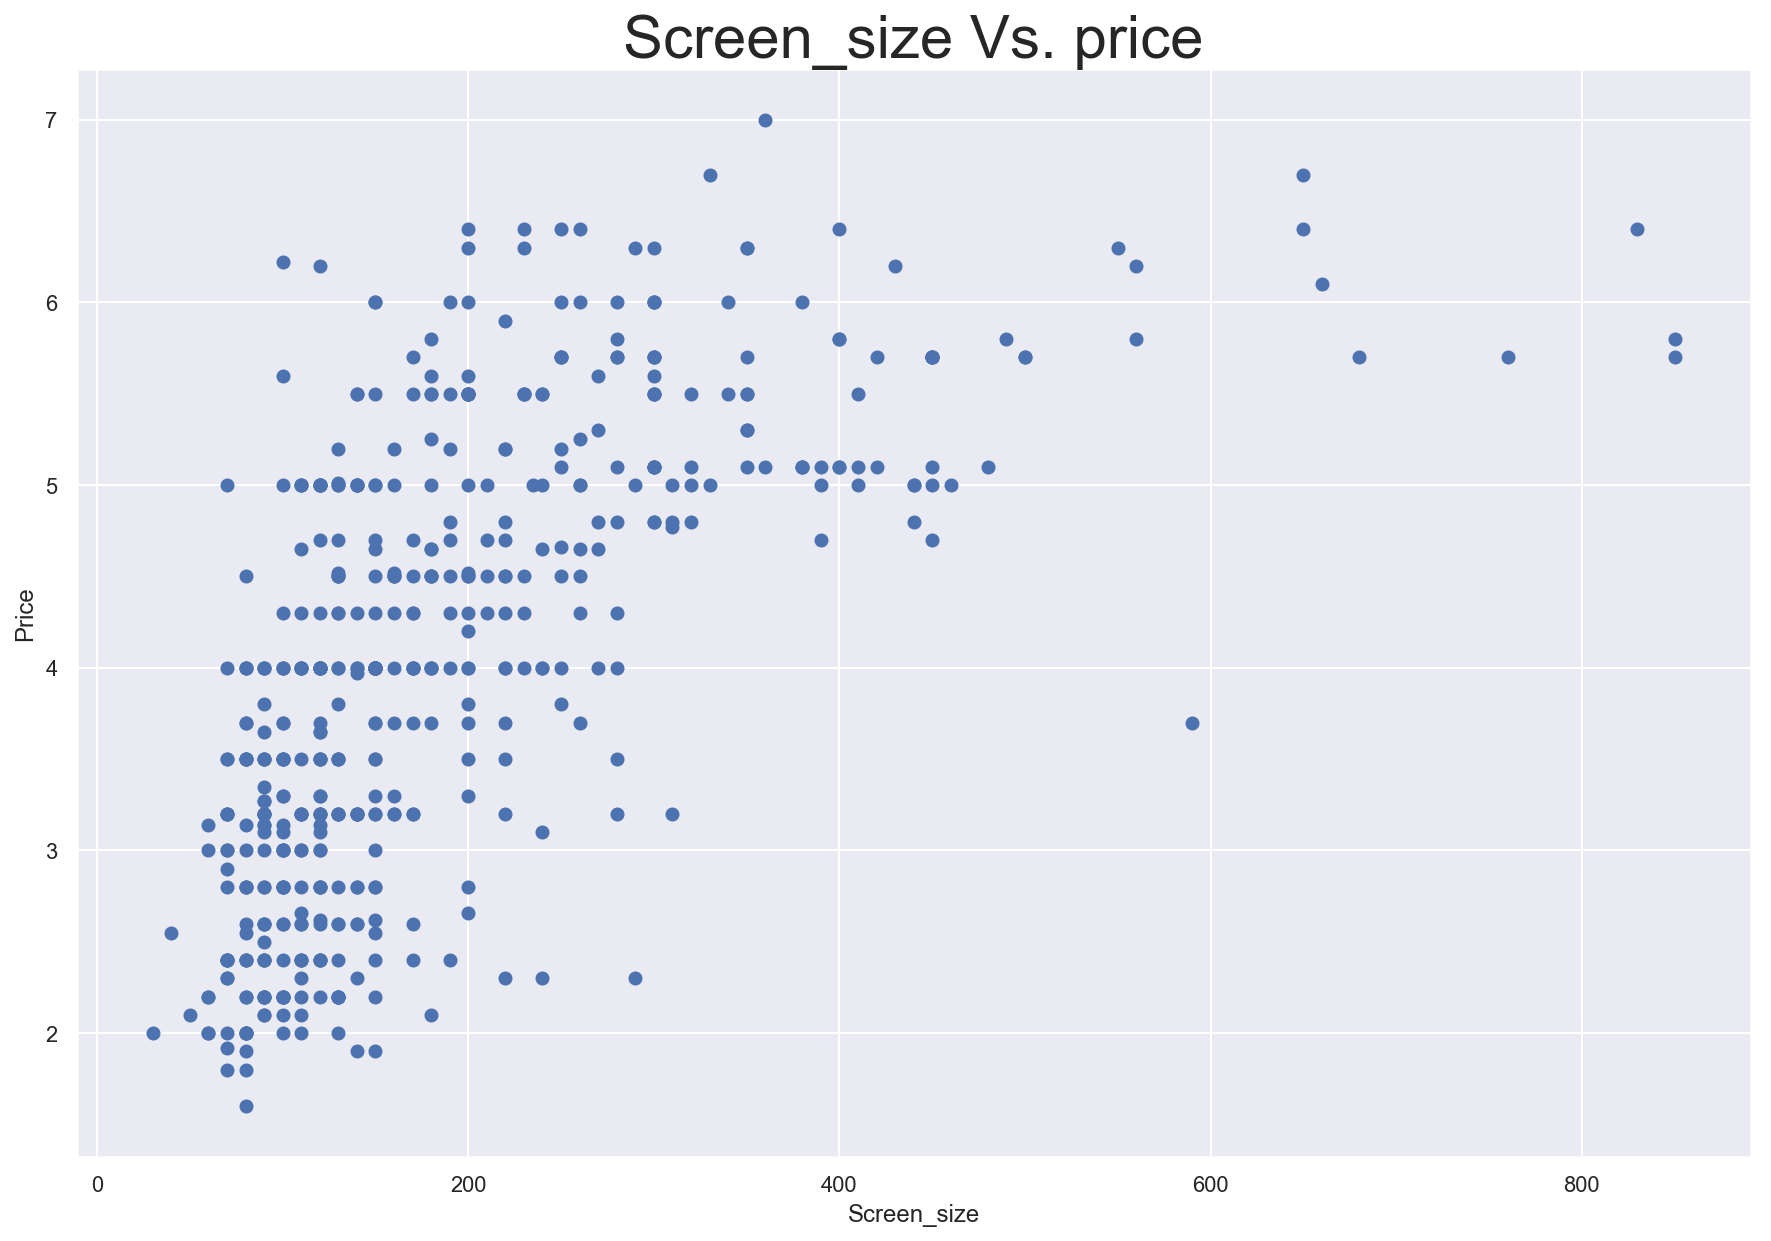

In [830]:
plt.figure(figsize=(15,10))
plt.title("Screen_size Vs. price",fontdict={"fontsize":30})
plt.xlabel("Screen_size")
plt.ylabel("Price")
plt.scatter(y=phones_df["screen_size"],x=phones_df["paresed_price"],data = phones_df);
plt.savefig("Screen_size Vs. price.eps")

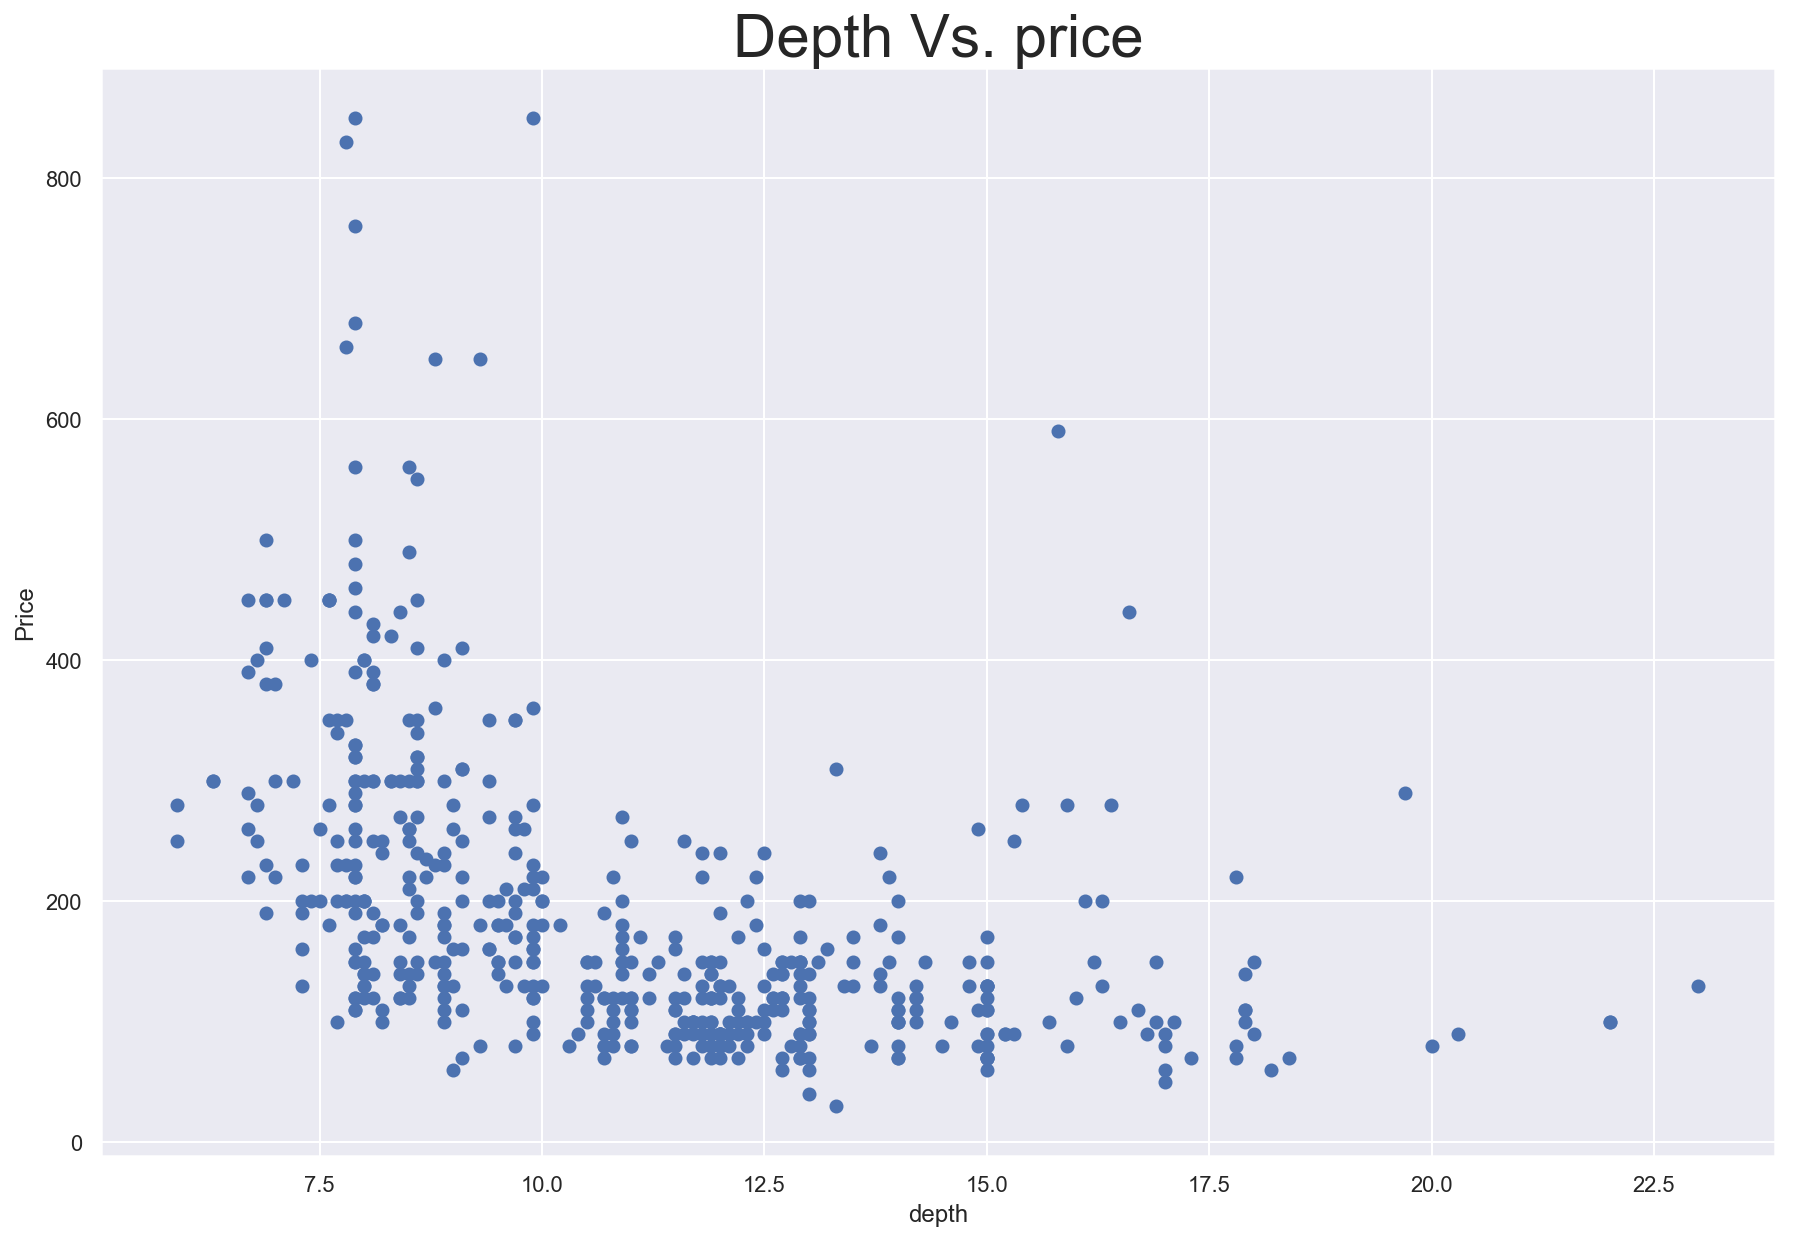

In [831]:
plt.figure(figsize=(15,10))
plt.title("Depth Vs. price",fontdict={"fontsize":30})
plt.xlabel("depth")
plt.ylabel("Price")
plt.scatter(phones_df["depth_mm"],y=phones_df["paresed_price"],data = phones_df);
plt.savefig("depth Vs. price.eps")

In [832]:
phones_df["log_price"] = np.log(phones_df["paresed_price"])

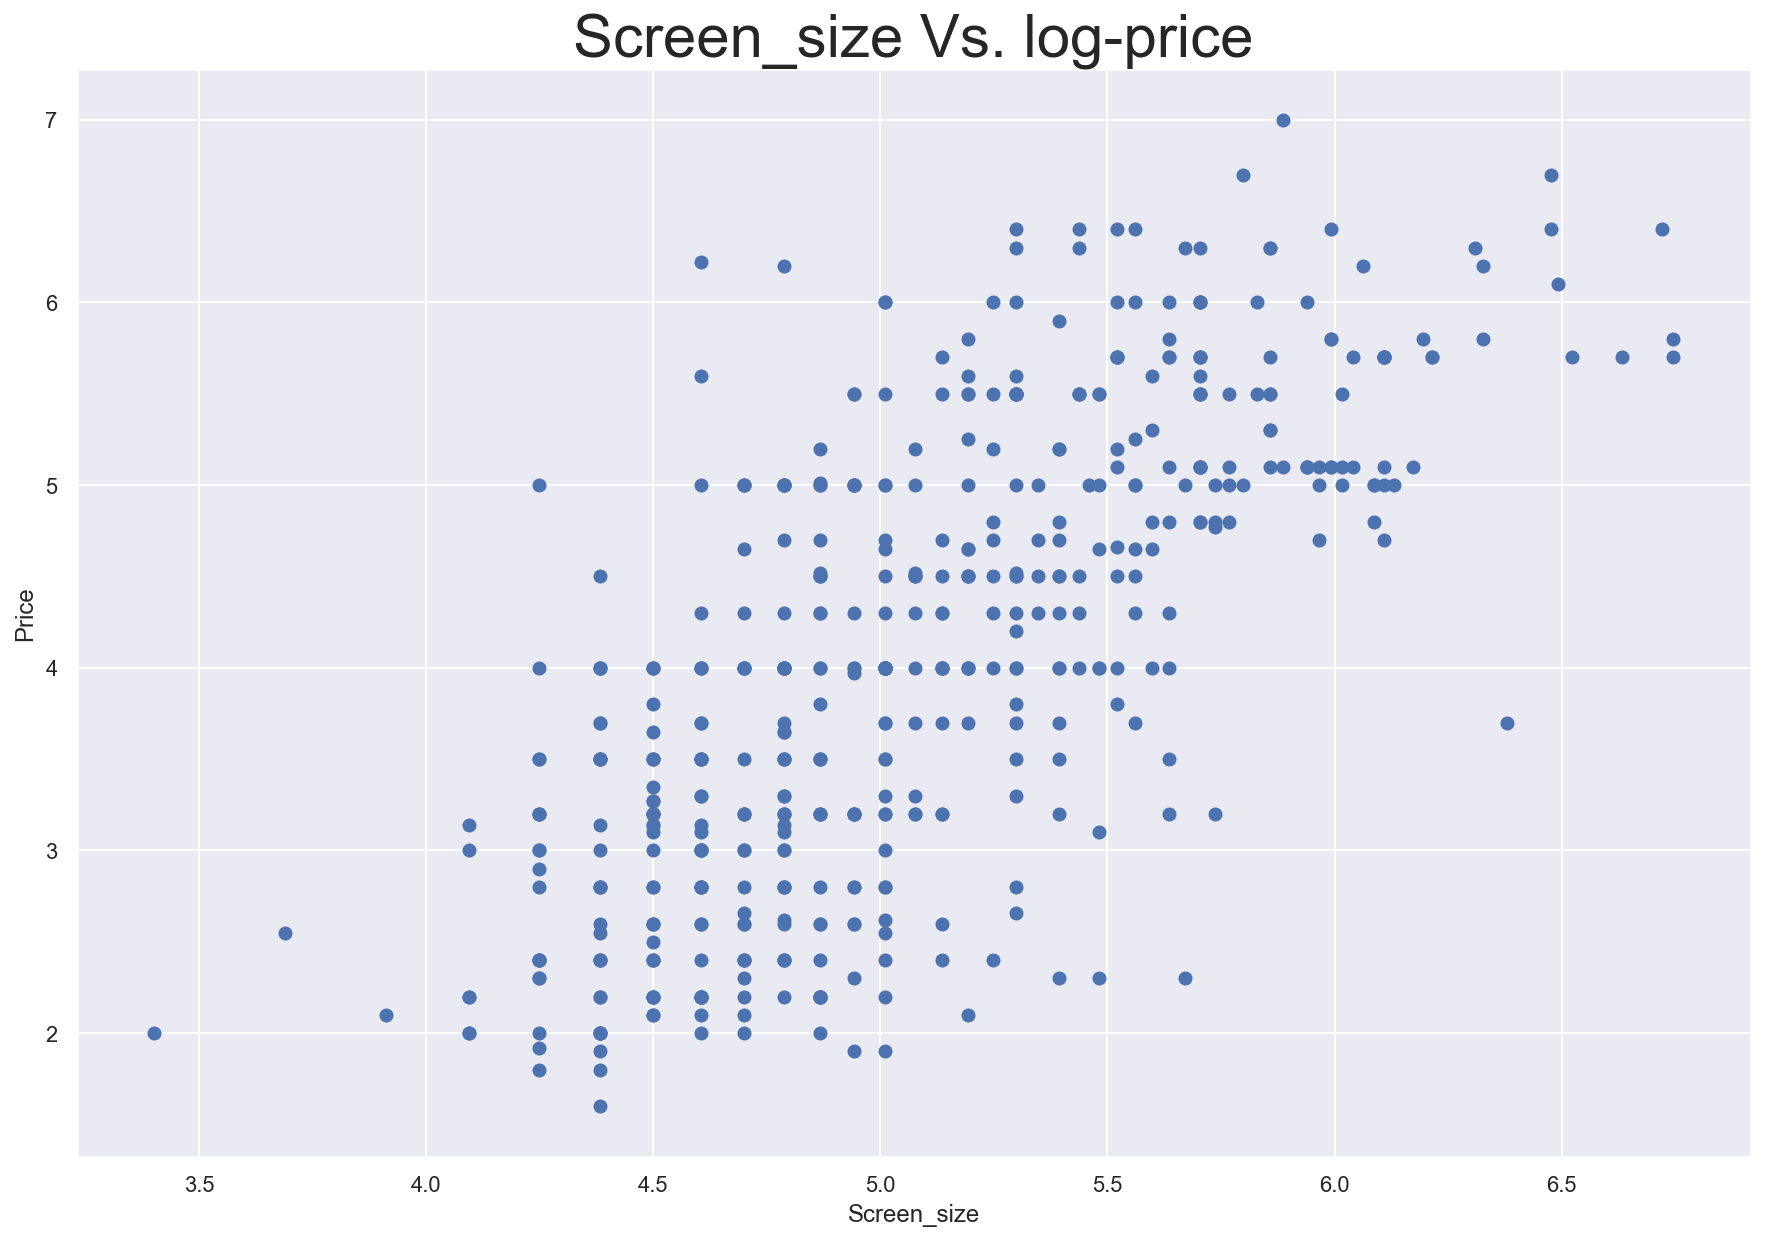

In [833]:
plt.figure(figsize=(15,10))
plt.title("Screen_size Vs. log-price",fontdict={"fontsize":30})
plt.xlabel("Screen_size")
plt.ylabel("Price")
plt.scatter(y=phones_df["screen_size"],x=phones_df["log_price"],data = phones_df);
plt.savefig("Screen_size Vs. log_price.eps")

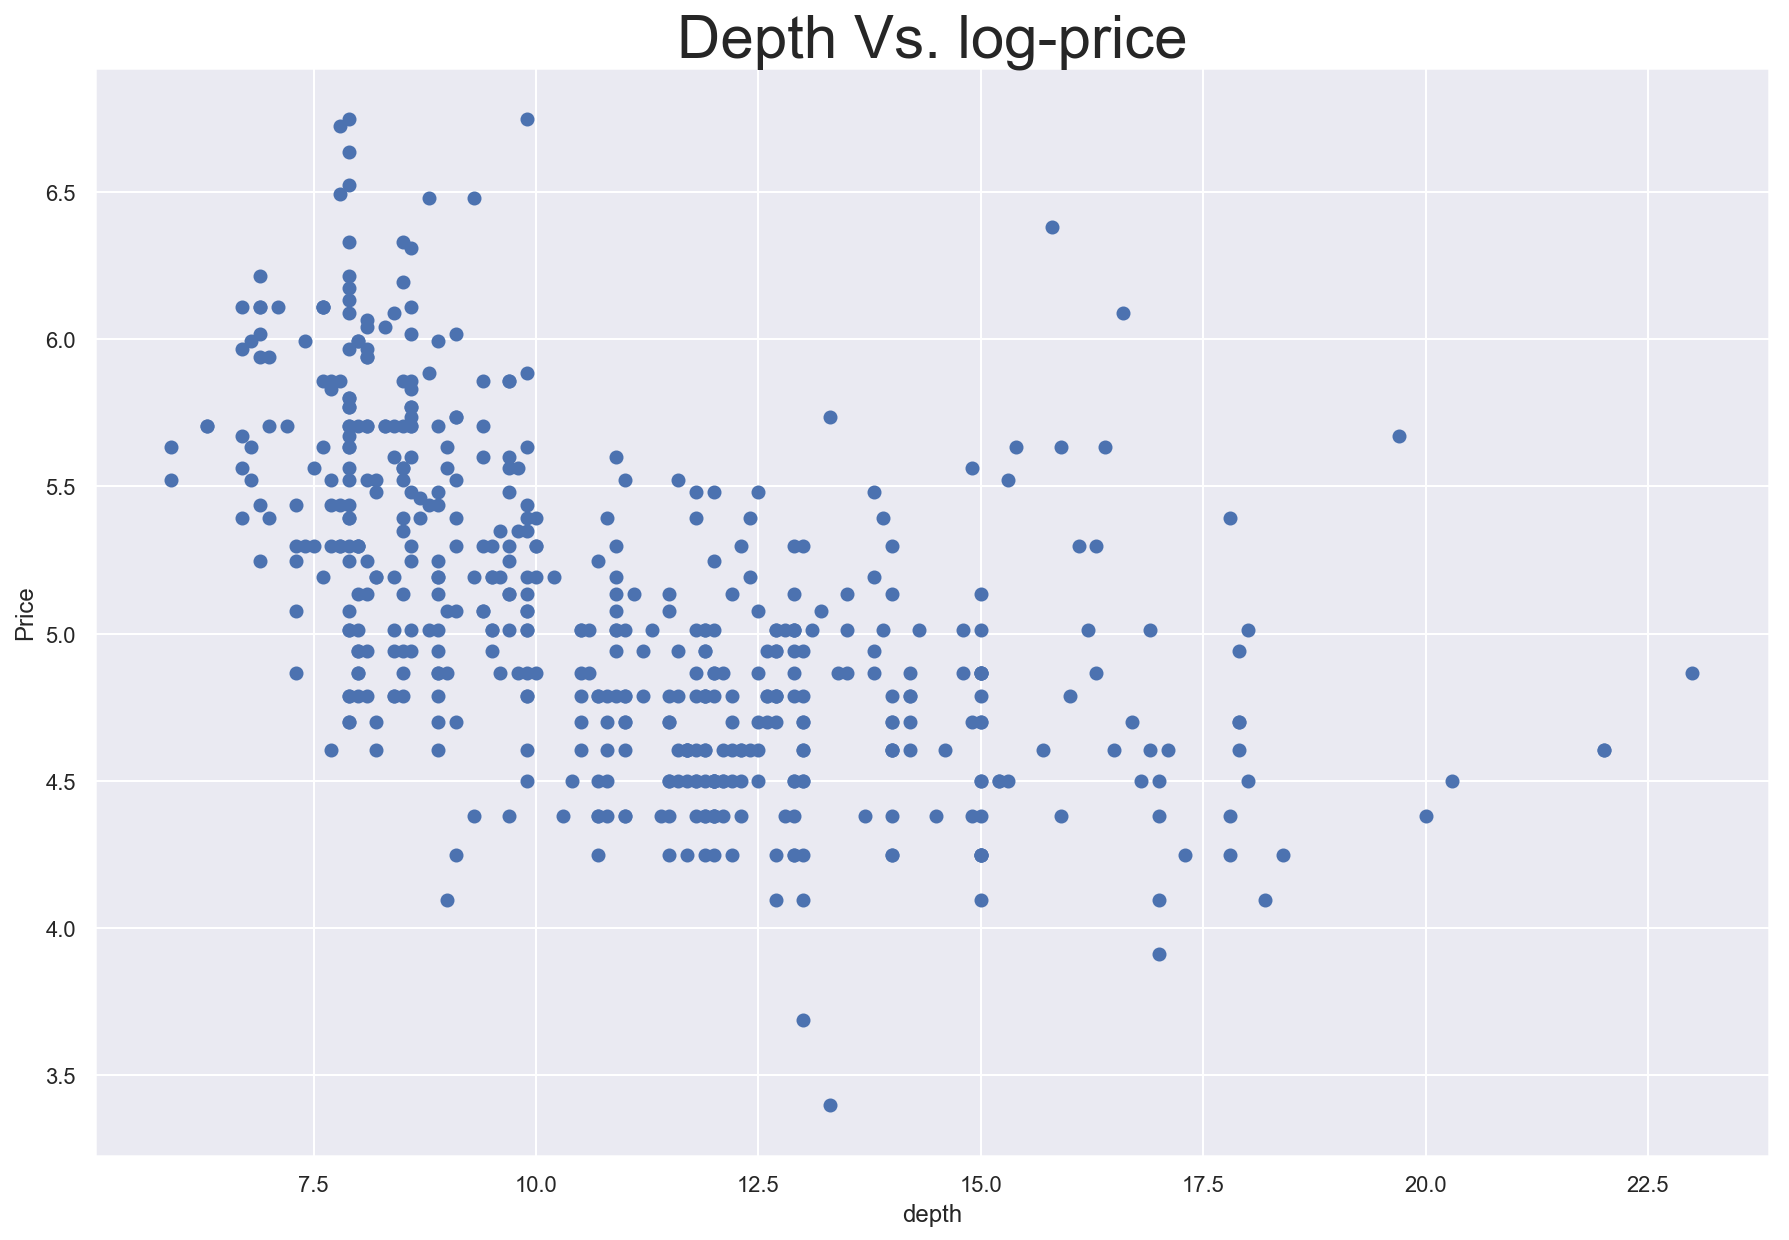

In [834]:
plt.figure(figsize=(15,10))
plt.title("Depth Vs. log-price",fontdict={"fontsize":30})
plt.xlabel("depth")
plt.ylabel("Price")
plt.scatter(phones_df["depth_mm"],y=phones_df["log_price"],data = phones_df);
plt.savefig("depth Vs. log_price.eps")

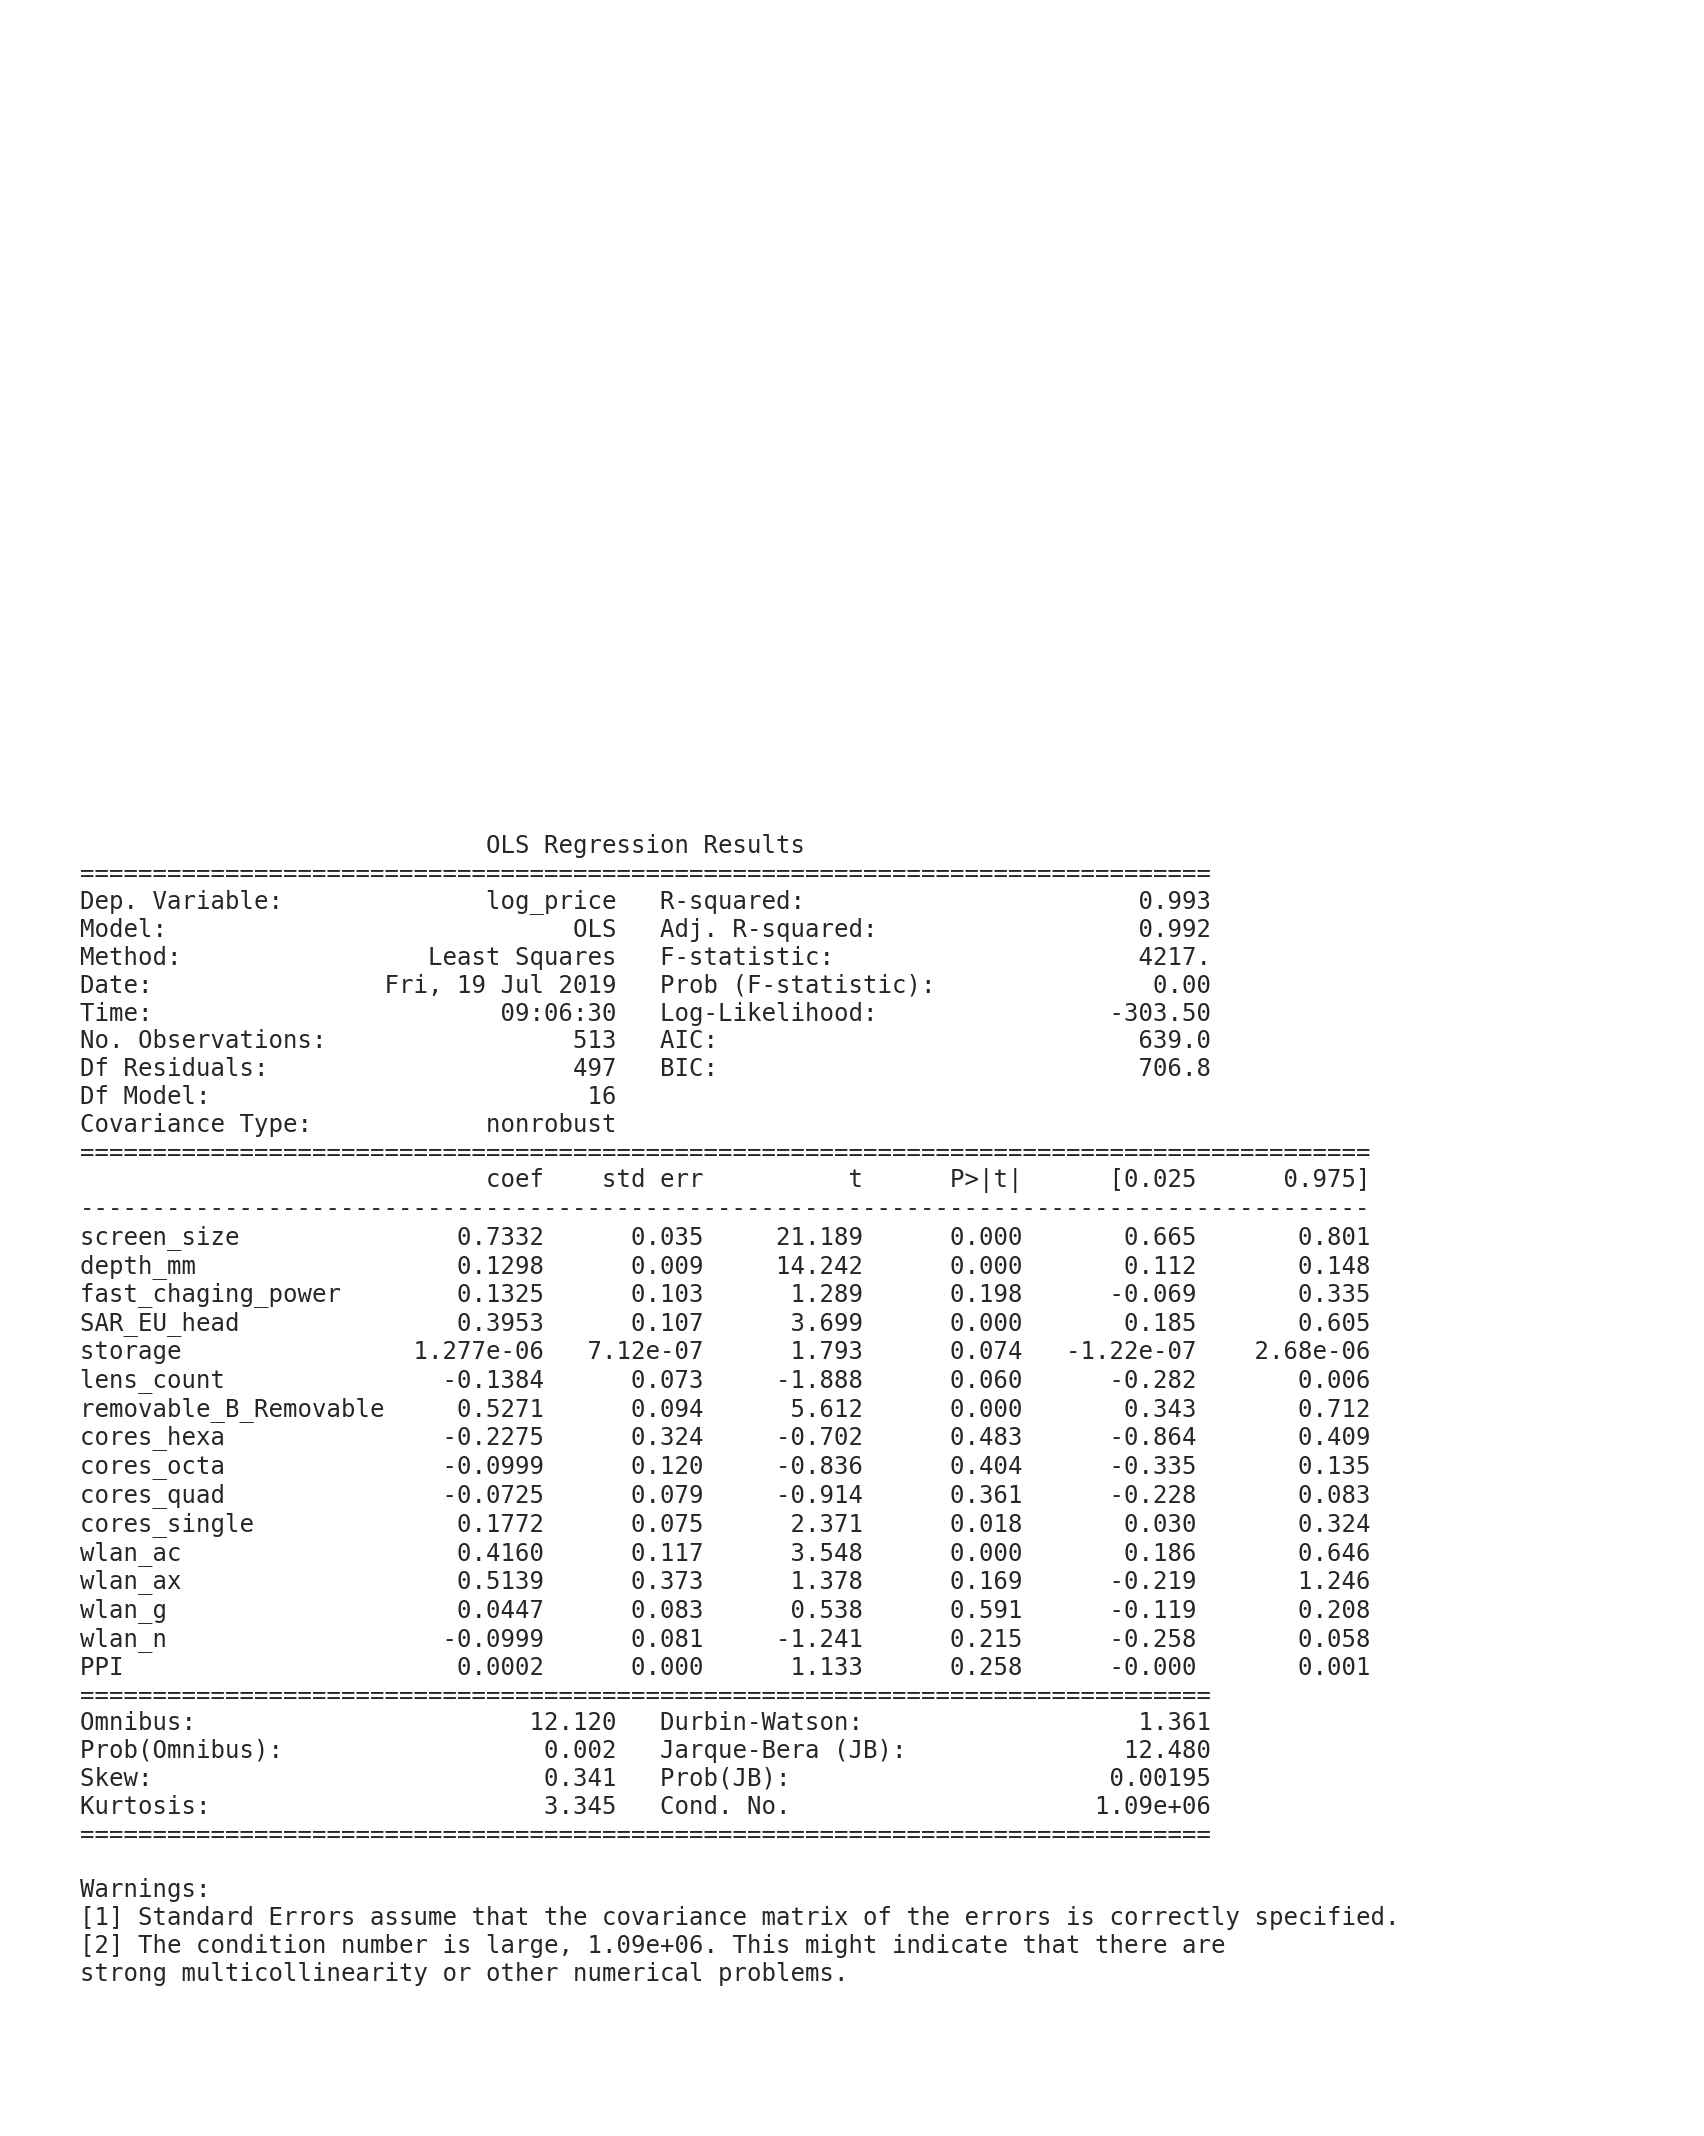

In [835]:
X = phones_df.loc[:,[x for x in phones_df if x not in  ["log_price","paresed_price",'predict','resid']]]
y  =  phones_df.loc[:,"log_price"]

model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 15))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(fit.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('output4.png')

In [836]:
a = split_and_validate(X,y)


Validation R^2 score was: 0.6841862459585637

Validation Adj R^2 score was: 0.6254301986950407
Feature coefficient results: 

screen_size : 0.17
depth_mm : 0.01
fast_chaging_power : 0.02
SAR_EU_head : -0.15
storage : 0.00
lens_count : -0.21
removable_B_Removable : 0.09
cores_hexa : -0.19
cores_octa : -0.20
cores_quad : -0.12
cores_single : -0.28
wlan_ac : 0.55
wlan_ax : 0.44
wlan_g : 0.18
wlan_n : 0.02
PPI : 0.00


In [837]:
phones_df['predict']=fit.predict(X)
phones_df['resid']=phones_df.paresed_price-phones_df.predict
phones_df["perc_error"] = phones_df['resid'].apply(abs)/phones_df.paresed_price
print("{}% is  the mean percentage ereor".format(round(100*phones_df["perc_error"].mean(),2)))
phones_df.drop(columns= ["perc_error"],inplace=True)

96.5% is  the mean percentage ereor


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


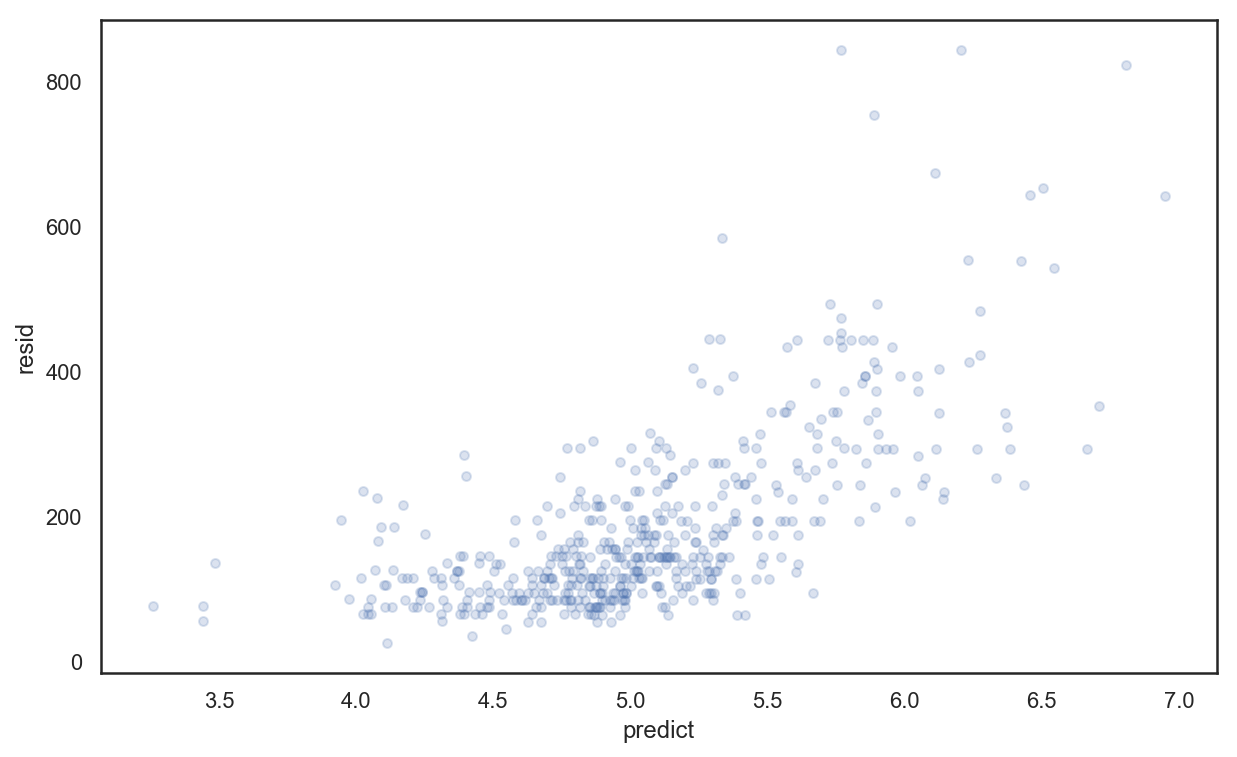

In [838]:
with sns.axes_style('white'):
    plot=phones_df.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))
plt.savefig("4th_resedual.eps");

In [839]:
phones_df = pd.read_csv("Cleaned_data.csv").join(pd.read_csv("PPI.csv"))

phones_df.set_index("phone",inplace= True)
phones_df.rename(columns={"0":"PPI"},inplace=True)
phones_df.drop(columns = "Unnamed: 0",inplace= True)
phones_df.drop(index=phones_df[phones_df["PPI"]!=phones_df["PPI"]].index,inplace=True)


In [840]:
X = phones_df.loc[:,[x for x in phones_df.columns if x != "paresed_price"]]
y=  phones_df.loc[:,"paresed_price"]

In [841]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=24)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=32)

In [842]:
lasso_model = Lasso(alpha = 1000) 
lasso_model.fit(X_train, y_train)

Lasso(alpha=1000, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [843]:
list(zip(X.columns, lasso_model.coef_))

[('screen_size', 0.0),
 ('announced_year', -0.0),
 ('length_mm', 0.0),
 ('width_mm', 0.0),
 ('depth_mm', -0.0),
 ('weight_oz', 0.0),
 ('screen ratio', 0.0),
 ('touchscreen', 0.0),
 ('total_pixels', 7.181891132061036e-05),
 ('card_slot', -0.0),
 ('battery_size', 0.005695195615574193),
 ('bluetooth_m', 0.0),
 ('fast_chaging_power', -0.0),
 ('SAR_EU_head', -0.0),
 ('storage', 0.0005471514127837676),
 ('lens_count', -0.0),
 ('removable_B_Removable', 0.0),
 ('cores_hexa', 0.0),
 ('cores_octa', -0.0),
 ('cores_quad', 0.0),
 ('cores_single', -0.0),
 ('gpu_manufacturer_Broadcom', 0.0),
 ('gpu_manufacturer_Mali', -0.0),
 ('gpu_manufacturer_NO', -0.0),
 ('gpu_manufacturer_PowerVR', 0.0),
 ('gpu_manufacturer_ULP', 0.0),
 ('gpu_manufacturer_Vivante', 0.0),
 ('wlan_ac', 0.0),
 ('wlan_ax', 0.0),
 ('wlan_g', 0.0),
 ('wlan_n', -0.0),
 ('network_g_4g', 0.0),
 ('network_g_5g', 0.0),
 ('network_g_nan', -0.0),
 ('PPI', -0.0)]

In [844]:
lr_model_ridge = Ridge(alpha = 1000)
lr_model_ridge.fit(X_train, y_train)

list(zip(X_train.columns, lr_model_ridge.coef_))

[('screen_size', 0.5738285726889825),
 ('announced_year', -4.59920843007494),
 ('length_mm', 0.463148383199582),
 ('width_mm', 2.262876539129123),
 ('depth_mm', 0.5004761902527389),
 ('weight_oz', 1.0359572534588783),
 ('screen ratio', 0.15012029469627342),
 ('touchscreen', 0.1950869216021193),
 ('total_pixels', 6.731092050572891e-05),
 ('card_slot', 0.003718697650081354),
 ('battery_size', -0.0047459746913097066),
 ('bluetooth_m', 0.7171584711345554),
 ('fast_chaging_power', -0.7789639055160379),
 ('SAR_EU_head', -0.12722033593738546),
 ('storage', 0.0006463263561141442),
 ('lens_count', -0.9244078398086113),
 ('removable_B_Removable', 1.2314694061236688),
 ('cores_hexa', 0.0932724214326813),
 ('cores_octa', -0.8304954975343302),
 ('cores_quad', 1.0478380743964413),
 ('cores_single', -1.2289982048344492),
 ('gpu_manufacturer_Broadcom', 0.029086299970221302),
 ('gpu_manufacturer_Mali', -0.8622233698300042),
 ('gpu_manufacturer_NO', -0.254273985863447),
 ('gpu_manufacturer_PowerVR', -0.

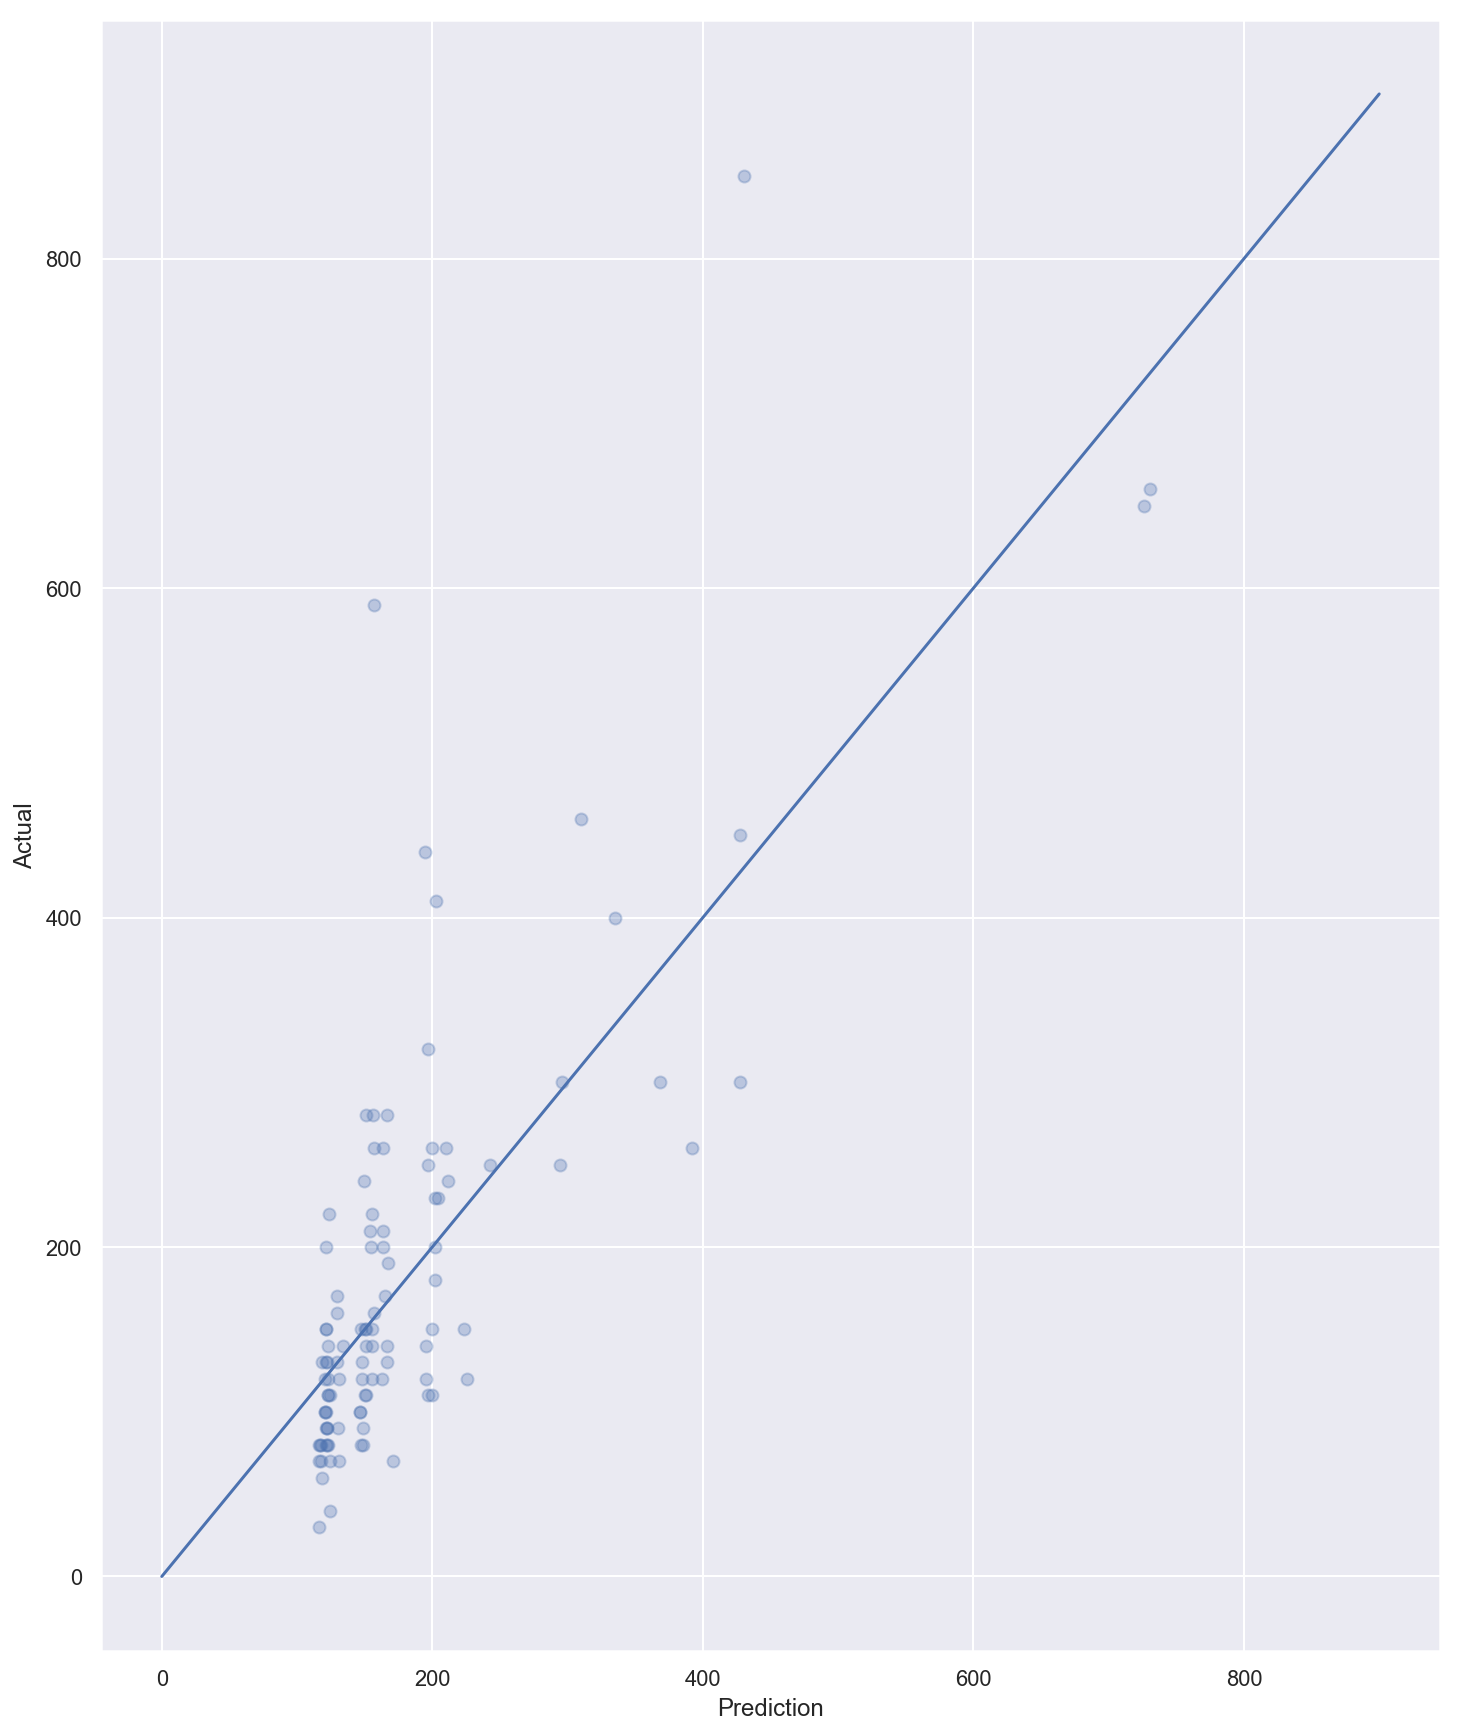

In [845]:
test_set_pred = lasso_model.predict(X_test)
plt.scatter(x = test_set_pred, y= y_test,alpha=.3)
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.plot(np.linspace(0,900,1000), np.linspace(0,900,1000));
plt.savefig("Lasso_r.eps")

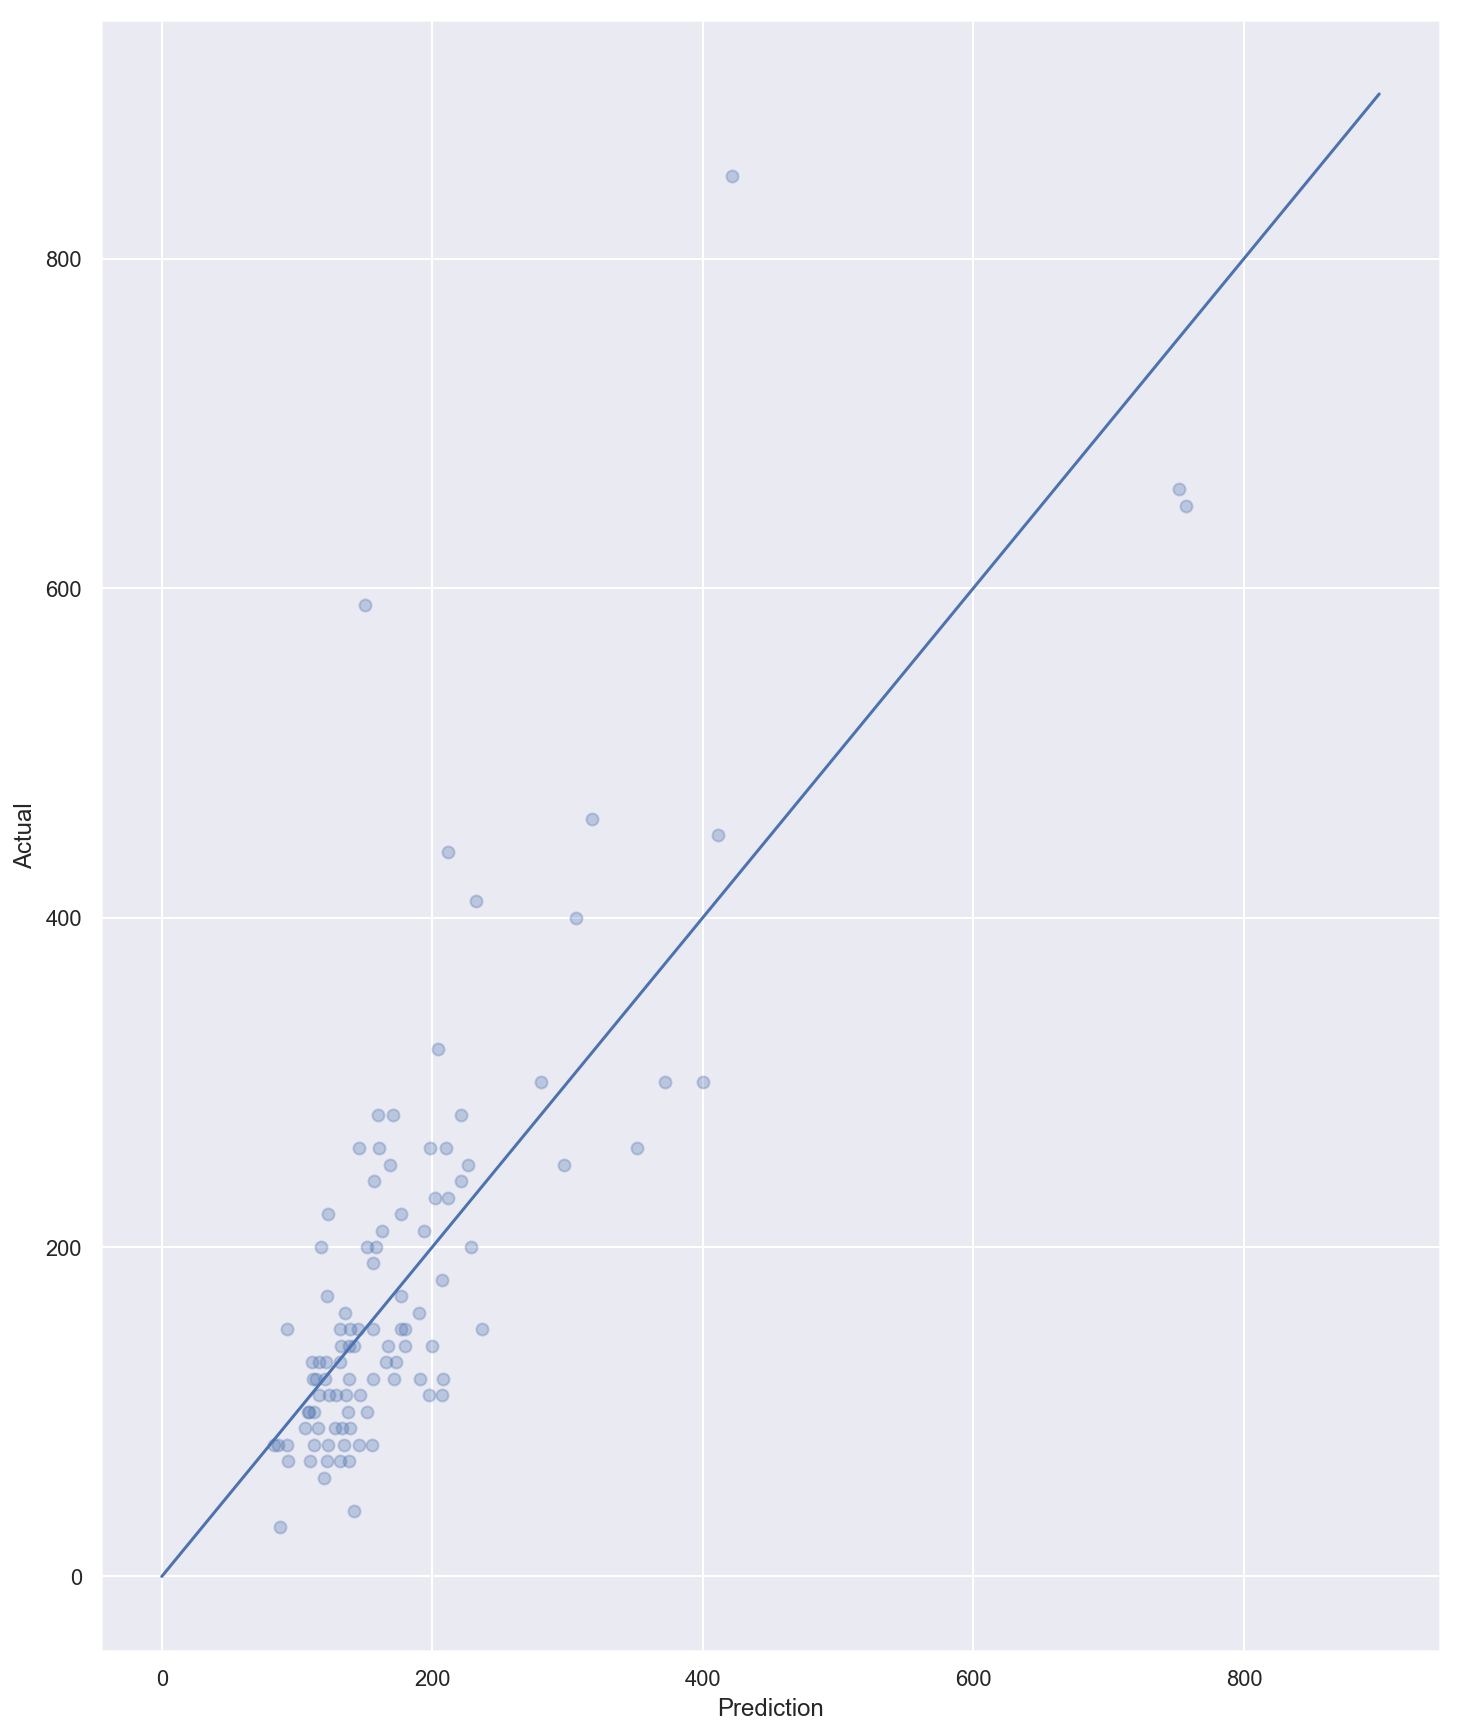

In [846]:
test_set_pred = lr_model_ridge.predict(X_test)
plt.scatter(x = test_set_pred, y= y_test,alpha=.3)
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.plot(np.linspace(0,900,1000), np.linspace(0,900,1000));
plt.savefig("Ridge_r.eps")

In [847]:
r2_score(y_test, test_set_pred)

0.5940380463430042

In [848]:
def mpe(y_true, y_pred):
    return (100*np.mean(np.abs(y_pred - y_true)/y_true))
def mae(y_true, y_pred):
    return (np.mean(np.abs(y_pred - y_true))) 

mpe(y_test, test_set_pred)

34.10132709325732

In [849]:
std = StandardScaler()
std.fit(X_train.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [850]:
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

In [884]:
lasso_model = Lasso(alpha = 90)
lasso_model.fit(X_tr,y_train)

Lasso(alpha=90, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [885]:
list(zip(X_train.columns, lasso_model.coef_))

[('screen_size', 0.0),
 ('announced_year', 0.0),
 ('length_mm', 0.0),
 ('width_mm', 0.0),
 ('depth_mm', -0.0),
 ('weight_oz', 0.0),
 ('screen ratio', 0.0),
 ('touchscreen', 0.0),
 ('total_pixels', 2.9815973193289773),
 ('card_slot', -0.0),
 ('battery_size', 0.0),
 ('bluetooth_m', 0.0),
 ('fast_chaging_power', 0.0),
 ('SAR_EU_head', -0.0),
 ('storage', 0.0),
 ('lens_count', 0.0),
 ('removable_B_Removable', -0.0),
 ('cores_hexa', 0.0),
 ('cores_octa', 0.0),
 ('cores_quad', 0.0),
 ('cores_single', -0.0),
 ('gpu_manufacturer_Broadcom', 0.0),
 ('gpu_manufacturer_Mali', 0.0),
 ('gpu_manufacturer_NO', -0.0),
 ('gpu_manufacturer_PowerVR', -0.0),
 ('gpu_manufacturer_ULP', -0.0),
 ('gpu_manufacturer_Vivante', 0.0),
 ('wlan_ac', 0.0),
 ('wlan_ax', 0.0),
 ('wlan_g', -0.0),
 ('wlan_n', -0.0),
 ('network_g_4g', 0.0),
 ('network_g_5g', 0.0),
 ('network_g_nan', -0.0),
 ('PPI', 0.0)]

In [853]:
alphalist = 10**(np.linspace(-2,5,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train.values, y_train)
    
    val_set_pred = pipe.predict(X_val.values)
    err_vec_val[i] = mpe(y_val, val_set_pred)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

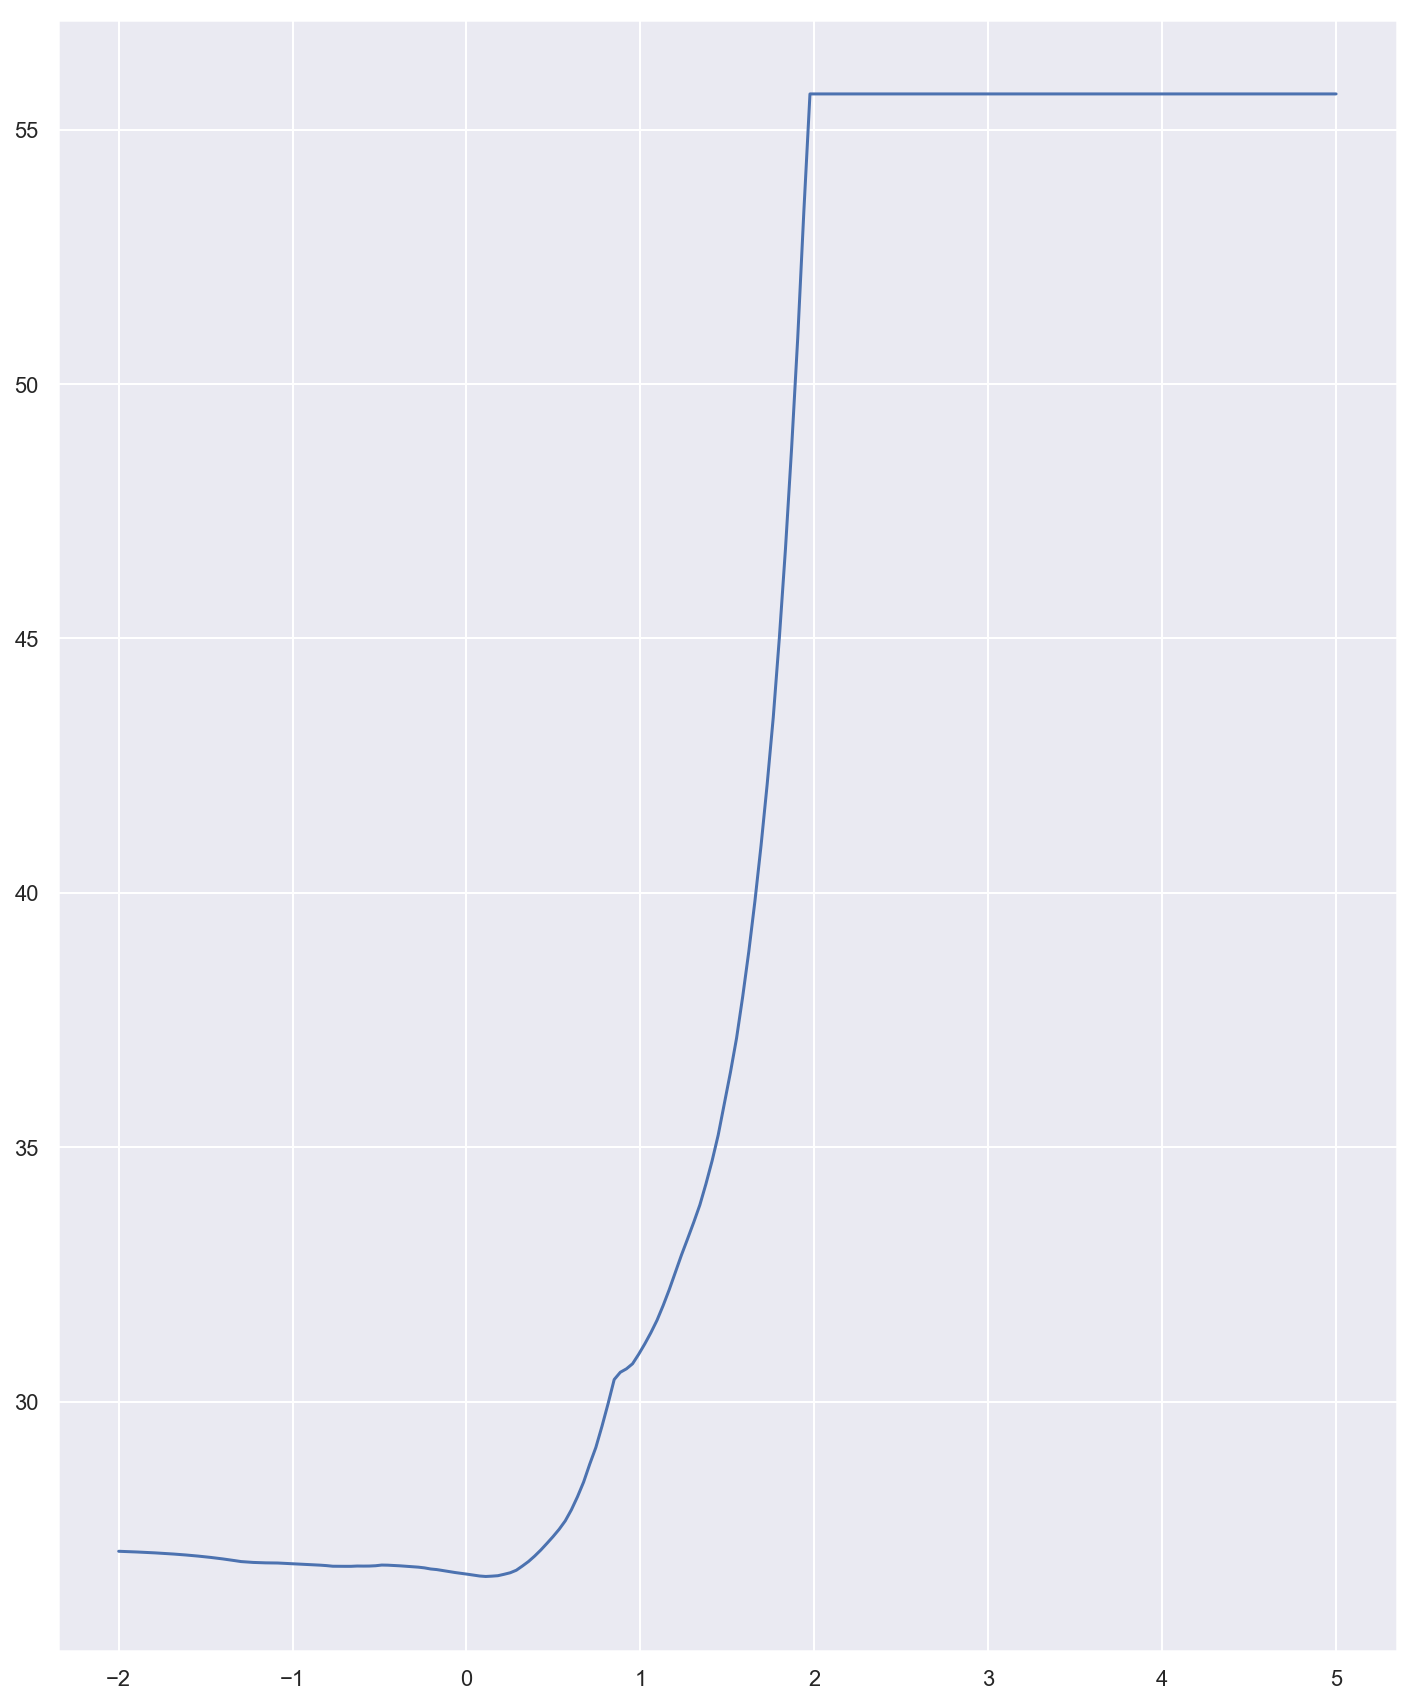

In [854]:
plt.plot(np.log10(alphalist), err_vec_val)
plt.savefig("Lasso.eps")

In [855]:
np.min(err_vec_val)

26.563622450024177

In [856]:
alphalist[np.argmin(err_vec_val)]

1.289890261253308

In [857]:
alphalist = 10**(np.linspace(-2,5,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):
    steps = [('standardize', StandardScaler()), 
             ('ridge', Ridge(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train.values, y_train)
    
    val_set_pred = pipe.predict(X_val.values)
    err_vec_val[i] = mpe(y_val, val_set_pred)

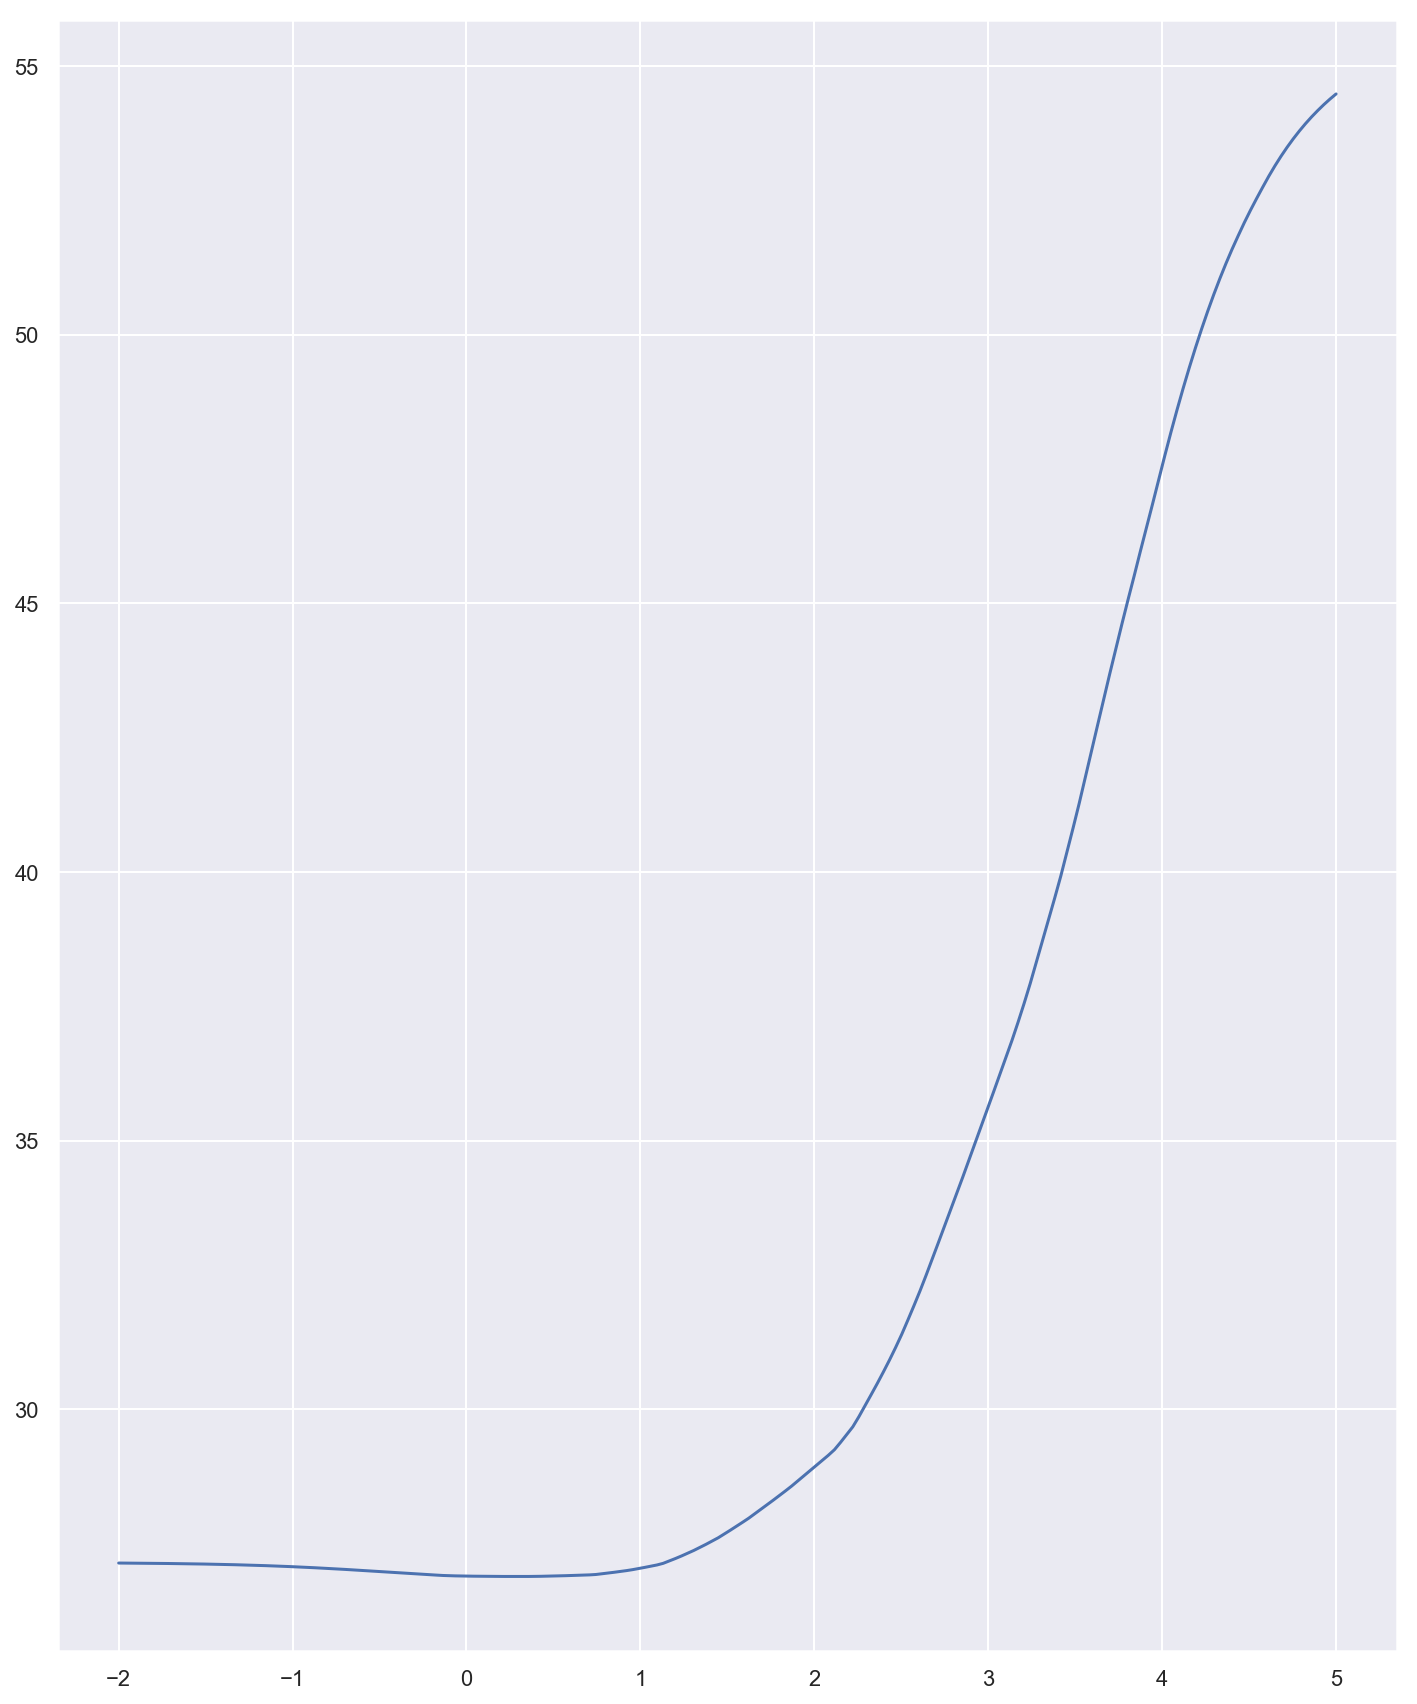

In [858]:
plt.plot(np.log10(alphalist), err_vec_val)
plt.savefig("Ridge.eps")

In [859]:
alphalist[np.argmin(err_vec_val)]

1.9338917504552302

In [860]:
np.min(err_vec_val)

26.88718131934514

In [861]:
std = StandardScaler()
std.fit(X_train.values)
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)


alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000e-02, 1.04737e-02, ..., 9.54772e+01, 1.00000e+02]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=None, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [862]:
lasso_model.alpha_

0.21214517849106299

In [863]:
list(zip(X_train.columns, lasso_model.coef_))

[('screen_size', 20.13425586673836),
 ('announced_year', -37.44750339998666),
 ('length_mm', 0.0),
 ('width_mm', -5.627115037416328),
 ('depth_mm', 0.17476120783349877),
 ('weight_oz', 16.215081634247507),
 ('screen ratio', 0.0),
 ('touchscreen', -0.22867831455720902),
 ('total_pixels', 59.84649313661654),
 ('card_slot', -5.499382654443161),
 ('battery_size', 1.611886641283054),
 ('bluetooth_m', 5.567932104798744),
 ('fast_chaging_power', -11.55764728492675),
 ('SAR_EU_head', 0.49784750728615124),
 ('storage', 15.591262814593923),
 ('lens_count', -7.542705143563716),
 ('removable_B_Removable', 4.859065888180246),
 ('cores_hexa', 2.829405656682743),
 ('cores_octa', 0.146449179754181),
 ('cores_quad', 1.045470023469083),
 ('cores_single', -27.868119508057543),
 ('gpu_manufacturer_Broadcom', -0.61281797388109),
 ('gpu_manufacturer_Mali', -11.598547578773605),
 ('gpu_manufacturer_NO', 0.44379609210468923),
 ('gpu_manufacturer_PowerVR', -3.979389944279127),
 ('gpu_manufacturer_ULP', -4.7147

In [864]:
test_set_pred = lasso_model.predict(X_te)

In [865]:
mpe(y_test, test_set_pred)

27.713352669259244

In [866]:
r2_score(y_test, test_set_pred)

0.6699974575232632

In [867]:
std = StandardScaler()
std.fit(X_train.values)
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)


alphavec = 10**np.linspace(-2,2,200)

Ridge_model = RidgeCV(alphas = alphavec, cv=5)
Ridge_model.fit(X_tr, y_train)

RidgeCV(alphas=array([1.00000e-02, 1.04737e-02, ..., 9.54772e+01, 1.00000e+02]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [868]:
Ridge_test_set_pred = Ridge_model.predict(X_te)

In [869]:
mpe(y_test, Ridge_test_set_pred)

28.195780633793248

In [870]:
r2_score(y_test, test_set_pred)

0.6699974575232632

In [871]:
from sklearn.linear_model import lars_path

In [872]:
X_tr = std.transform(X_train.values)

In [873]:
alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso')

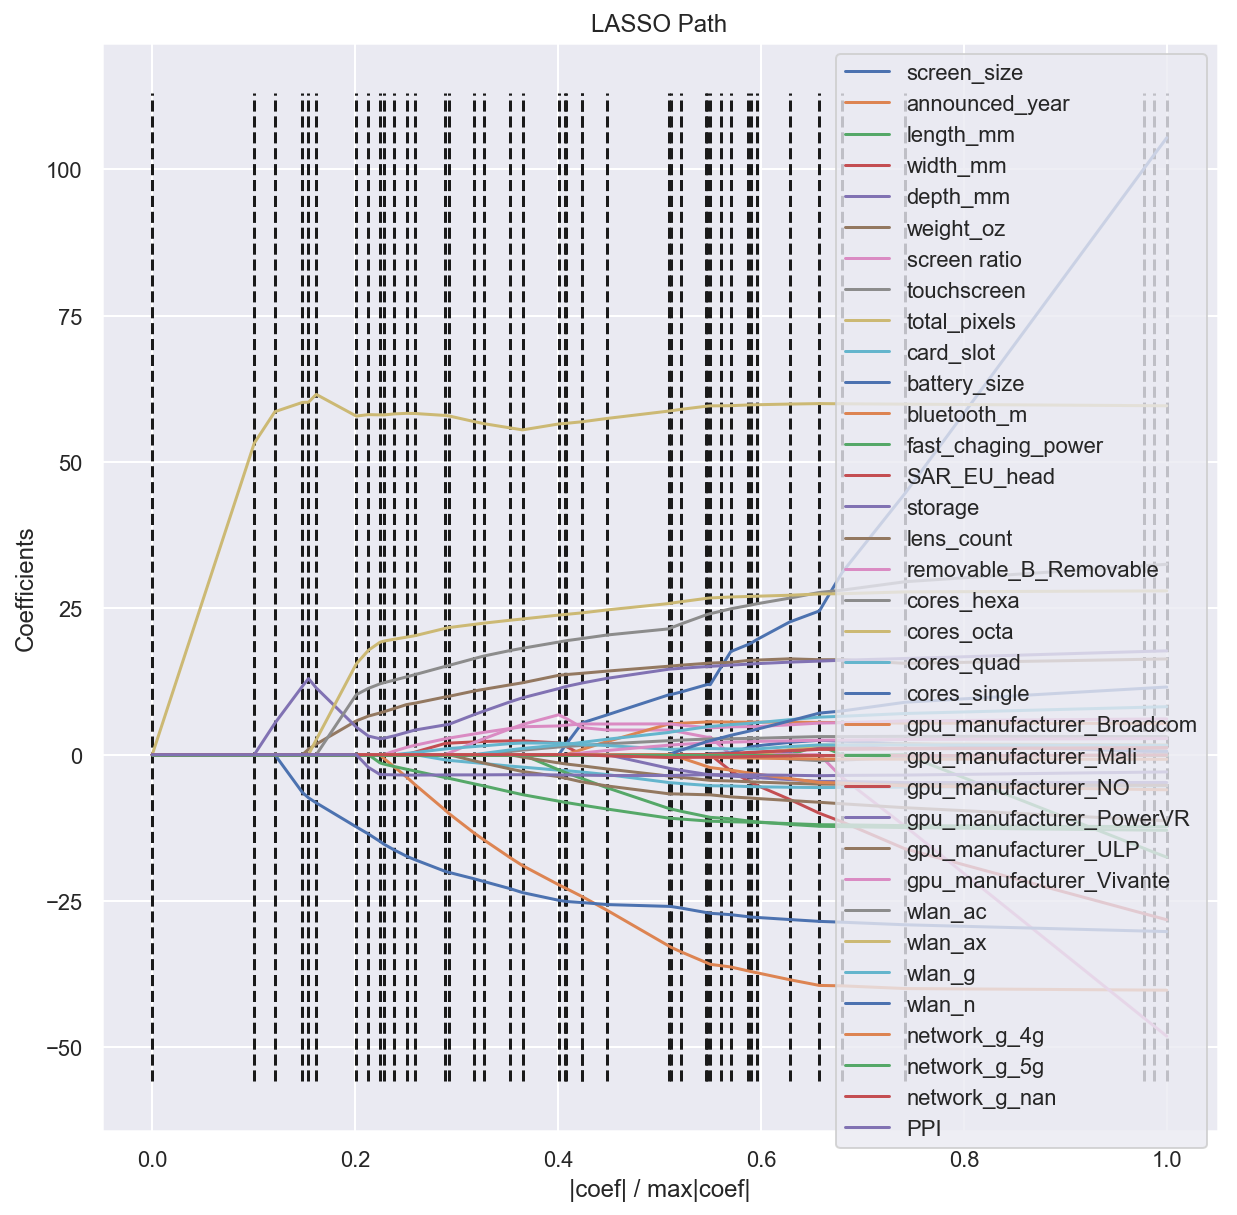

<Figure size 864x1080 with 0 Axes>

In [874]:

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()
plt.savefig("LASSO path.eps")